<a href="https://colab.research.google.com/github/leobioinf0/Supervitat_Regressio/blob/main/S09_T02_Supevised_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Supervised Regressions**

Course: *Data Science amb Python*

Sprint: *9. Supervised Learning - Regressions*


Task: *S09 T02: Supervised Learning - Regressions*

Date: *2022-01-06*

[Leo Madsen](https://github.com/leobioinf0)




#### Exercises: 
- Level 1
    - Exercise 1:
    
    Create at least three different regression models to try to best predict DelayedFlights.csv flight delay (ArrDelay).
    - Exercise 2: 
    
    Compare them based on MSE and R2.
    - Exercise 3: 
    
    Train them using the different parameters they support
    - Exercise 4: 
    
    Compare your performance using the traint / test approach or using all data (internal validation)
- Level 2
    - Exercise 5: 
    
    Perform some variable engineering process to improve prediction
- Level 3
    - Exercise 6: 
    
    Do not use the DepDelay variable when making predictions

# Prerequisites

## Upgrade modules

In [ ]:
!pip install --upgrade pip
!pip install --upgrade matplotlib
!pip install --upgrade scikit-learn
!pip install --upgrade numpy
!pip install --upgrade keras
!pip install --upgrade tensorflow
!pip install --upgrade pandas
!pip install --upgrade xgboost
!pip install --upgrade feature-engine

## Load modules

In [2]:
## System
import os
import pickle
import glob

## Data treatment
import pandas as pd
import numpy as np
import datetime
import math 
from scipy.stats import sem

## Preprocessing and modeling
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from feature_engine.creation import CyclicalTransformer

## Warnings configuration
import warnings
warnings.filterwarnings('ignore')

## Graphics
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display
from tqdm import tqdm_notebook
from google.colab import data_table
data_table.enable_dataframe_formatter()
data_table.DataTable.max_columns = 50
data_table.DataTable.num_rows_per_page = 55
data_table.DataTable.max_rows = 56

In [3]:
%matplotlib inline
sns.set(rc={'figure.figsize':(15,5)})

## Define functions

In [4]:
def timenow():
    '''
    Return the current time in hours, minutes and seconds.
    '''
    return datetime.datetime.now().time().replace(microsecond=0)

def mk_dir(name):
    '''
    Create directory with the name passed in the case that it does not exist and return its full path.
    '''
    path = os.path.join(os.getcwd(), name)
    if not os.path.exists(path):
        try:
            os.makedirs(path, 0o700)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise
        print("Directory created: {}".format(path))
    else:
        print("Directory already existing: {}".format(path))
    return path

def rounder(n):
    """
    Round up to the first digit that is not zero
    """
    if n == 0:
        return n
    else:
        k = 1 - int(math.log10(n))
        return round(n, 1 if n > 1 else k)

def describer(dataframe):
    """
    Description of dataframe
    """
    desc_df = round(dataframe.describe(include="all"),2).T
    desc_df["unique"]=dataframe.nunique()
    desc_df["NullAny"]= dataframe.isnull().any()
    desc_df["NullSum"]=dataframe.isnull().sum()
    desc_df["NullPct"]=(dataframe.isnull().sum()/len(dataframe)*100).apply(rounder)
    desc_df["dtypes"]=dataframe.dtypes
    return(desc_df)


def kfcv_evaluator(X, y, model, n_s):
    '''
    Evaluate a R2 score by K-Folds cross-validation of a given model.
    '''
    # prepare the cross-validation procedure
    cv = KFold(n_splits=n_s, random_state=1, shuffle=True)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring='r2', cv=cv, verbose=3)
    return scores



def rkfcv_evaluator(X, y, model, n_s, n_r):
    '''
    Evaluate a R2 score by  Repeated K-Folds cross-validation of a given model.
    '''
    cv = RepeatedKFold(n_splits=n_s, n_repeats=n_r, random_state=1)
    scores = cross_val_score(model, X, y, scoring='r2', cv=cv, verbose=3)
    return scores


def numToTime(x):
    """
    Convert aeronautical time to datetime.time object
    """
    from datetime import time
    if pd.isnull(x):
        return np.nan
    else:
        x = str(int(x))
        h = x[:-2]
        if h == "" or h == "24":
            h = "0"
        m = x[-2:]
        return time(int(h), int(m))

def to_flat(regular_list):
    '''
    Flatten a given list.
    '''
    flat_list = [item for sublist in regular_list for item in sublist]
    return(flat_list)

def reg_metrics(name, model, X_test, y_true):
    '''
    Evaluate a regression model and calculate various metrics. Return the metrics in a dataframe
    '''
    y_pred = model.predict(X_test)
    me = max_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    ev = explained_variance_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    medae = median_absolute_error(y_true, y_pred)
    reg_metrics_df = pd.DataFrame(data=[[r2,mse, mae,  mape, ev,me, medae]], 
                                  columns=["R2","MSE", "MAE", "MAPE", "EV", "ME", "MedAE"], 
                                  index=[name])
    return(reg_metrics_df)

def rkfcv_to_df(results):
    """
    Tabulate the scores of a Given  dictionary with Repeated K-Folds cross-validation scores.
    And save the table to a .csv file. 
    """
    df = pd.DataFrame.from_dict({(i,j): rkfcv_results[i][j] 
                        for i in rkfcv_results.keys() 
                        for j in rkfcv_results[i].keys()},
                    orient='index')
    df.reset_index(level=[0,1], inplace=True)
    df.columns = ["model","n_splits"] + [str(i) for i in n_repeats]
    df.to_csv(rkfcv_filename_path+".csv")
    return df
    
def plot_rkfcv(df):
    """
    Boxplot of Repeated K-Folds cross-validation scores.
    """
    fig, axes = plt.subplots(nrows=df.model.nunique(), 
                            ncols=df.n_splits.nunique(),
                            figsize=(df.n_splits.nunique()*8,df.model.nunique()*4),
                            sharex=True, sharey = True)

    for i, modl in enumerate(df.model.unique()):
        for j, splts in enumerate(df.n_splits.unique()):
            data = df[(df.model==modl) & (df.n_splits==splts)][[str(i) for i in n_repeats]].apply(to_flat)
            axes[i][j].boxplot(data, showmeans=True)
            ttl="{} ({} splits)".format(modl, splts)
            axes[i][j].set_title(ttl, fontweight = "bold")

    fig.suptitle(t='Number of Repeats Performance Comparison in \nRepeated k-Fold Cross-Validation ', 
                fontsize = 18, fontweight = "bold")
    fig.supxlabel('Nº repeats',fontsize = 18, fontweight = "bold")
    fig.supylabel('R2 score',fontsize = 18, fontweight = "bold")

    filename = "All_Repeated_K-fold_cv.png"
    plt.savefig(os.path.join(exe04_plots_path, filename))
    plt.show()

## Directories

In [6]:
# Definir el directorio de trabajo
#cwd = '/content/drive/MyDrive/Data_Science_amb_Python/Sprint12-Aprenentatge_Supervisat_Regressions/Supervitat_Regressio'
cwd = './'
os.chdir(cwd)
print(os.getcwd())

/content/drive/MyDrive/Data_Science_amb_Python/Sprint12-Aprenentatge_Supervisat_Regressions/Supervitat_Regressio


# Read Data

In [7]:
# Read a smaller version of the dataset from raw.githubusercontent
filepath = "https://raw.githubusercontent.com/leobioinf0/Supervitat_Regressio/main/DelayedFlights3mb.csv"
df = pd.read_csv(filepath, index_col=0)
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
192313,2008,1,28,1,833.0,825,1122.0,1118,NW,282,N506US,109.0,113.0,90.0,4.0,8.0,MEM,DTW,610,8.0,11.0,0,N,0,NaN,NaN,NaN,NaN,NaN
139043,2008,7,27,7,1905.0,1815,1955.0,1910,MQ,3497,N842AE,50.0,55.0,32.0,45.0,50.0,DFW,SHV,190,4.0,14.0,0,N,0,8.0,0.0,0.0,0.0,37.0
28582,2008,10,8,3,1725.0,1550,2034.0,1847,OH,6779,N924CA,189.0,177.0,131.0,107.0,95.0,LGA,JAX,834,6.0,52.0,0,N,0,0.0,0.0,12.0,0.0,95.0
157571,2008,8,4,1,1836.0,1825,2141.0,2140,WN,618,N750SA,125.0,135.0,113.0,1.0,11.0,SMF,DEN,910,6.0,6.0,0,N,0,NaN,NaN,NaN,NaN,NaN
166602,2008,1,17,4,1614.0,1555,1718.0,1712,XE,2818,N14991,64.0,77.0,49.0,6.0,19.0,IAH,JAN,351,4.0,11.0,0,N,0,NaN,NaN,NaN,NaN,NaN


____________________
This dataset is composed by the following variables: 

1.	**Year**	2016
2.	**Month**	1-12
3.	**DayofMonth**	1-31
4.	**DayOfWeek**	1 (Monday) - 7 (Sunday)
5.	**DepTime**	actual departure time (local, hhmm)
6.	**CRSDepTime**	scheduled departure time (local, hhmm)
7.	**ArrTime**	actual arrival time (local, hhmm)
8.	**CRSArrTime**	scheduled arrival time (local, hhmm)
9.	**UniqueCarrier**	unique carrier code
10.	**FlightNum**	flight number
11.	**TailNum** plane tail number: aircraft registration, unique aircraft identifier
12.	**ActualElapsedTime**	in minutes
13.	**CRSElapsedTime**	in minutes
14.	**AirTime**	in minutes
15.	**ArrDelay**	arrival delay, in minutes: **A flight is counted as "on time" if it operated less than 15 minutes later the scheduled time shown in the carriers' Computerized Reservations Systems (CRS).** 
16.	**DepDelay**	departure delay, in minutes
17.	**Origin**	origin IATA airport code
18.	**Dest**	destination IATA airport code
19.	**Distance**	in miles
20.	**TaxiIn**	taxi in time, in minutes
21.	**TaxiOut**	taxi out time in minutes
22.	**Cancelled**	*was the flight cancelled
23.	**CancellationCode**	reason for cancellation (A = carrier, B = weather, C = NAS, D = security)
24.	**Diverted**	1 = yes, 0 = no
25.	**CarrierDelay**	in minutes: Carrier delay is within the control of the air carrier. Examples of occurrences that may determine carrier delay are: aircraft cleaning, aircraft damage, awaiting the arrival of connecting passengers or crew, baggage, bird strike, cargo loading, catering, computer, outage-carrier equipment, crew legality (pilot or attendant rest), damage by hazardous goods, engineering inspection, fueling, handling disabled passengers, late crew, lavatory servicing, maintenance, oversales, potable water servicing, removal of unruly passenger, slow boarding or seating, stowing carry-on baggage, weight and balance delays.
26.	**WeatherDelay**	in minutes: Weather delay is caused by extreme or hazardous weather conditions that are forecasted or manifest themselves on point of departure, enroute, or on point of arrival.
27.	**NASDelay**	in minutes: Delay that is within the control of the National Airspace System (NAS) may include: non-extreme weather conditions, airport operations, heavy traffic volume, air traffic control, etc. 
28.	**SecurityDelay**	in minutes: Security delay is caused by evacuation of a terminal or concourse, re-boarding of aircraft because of security breach, inoperative screening equipment and/or long lines in excess of 29 minutes at screening areas.
29.	**LateAircraftDelay**	in minutes: Arrival delay at an airport due to the late arrival of the same aircraft at a previous airport. The ripple effect of an earlier delay at downstream airports is referred to as delay propagation.

In [8]:
# Full description of dataframe
describer(df)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,NullAny,NullSum,NullPct,dtypes
Year,20336.0,1,NaN,NaN,2008.0,0.0,2008.0,2008.0,2008.0,2008.0,2008.0,False,0,0.000,int64
Month,20336.0,12,NaN,NaN,6.11,3.48,1.0,3.0,6.0,9.0,12.0,False,0,0.000,int64
DayofMonth,20336.0,31,NaN,NaN,15.75,8.78,1.0,8.0,16.0,23.0,31.0,False,0,0.000,int64
DayOfWeek,20336.0,7,NaN,NaN,3.98,2.0,1.0,2.0,4.0,6.0,7.0,False,0,0.000,int64
DepTime,20336.0,1195,NaN,NaN,1516.24,451.92,1.0,1201.0,1544.0,1869.25,2400.0,False,0,0.000,float64
CRSDepTime,20336.0,1013,NaN,NaN,1465.7,426.15,1.0,1130.75,1508.0,1815.0,2359.0,False,0,0.000,int64
ArrTime,20277.0,1293,NaN,NaN,1604.49,551.68,1.0,1310.0,1712.0,2030.0,2400.0,True,59,0.300,float64
CRSArrTime,20336.0,1187,NaN,NaN,1630.69,467.13,1.0,1320.0,1705.0,2013.0,2359.0,False,0,0.000,int64
UniqueCarrier,20336,20,WN,3895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0,0.000,object
FlightNum,20336.0,5647,NaN,NaN,2213.61,1958.18,1.0,619.0,1553.0,3537.25,7828.0,False,0,0.000,int64


# Preprocessing

## Cancelled/CancellationCode

- First we eliminate all the flights that were canceled since they do not provide information.
- Then we remove the columns ["Canceled", "CancellationCode"]

In [9]:
df = df[df.Cancelled==0].copy()
df.drop(labels=["Cancelled", "CancellationCode"], axis=1, inplace=True)

## Diverted
- First we eliminate all the flights that were diverted since they do not provide information.
- Then we remove the column ["Diverted"]

In [10]:
df = df[df.Diverted==0].copy()
df.drop(labels=["Diverted"], axis=1, inplace=True)

## Missing in ArrDelay

- We eliminate the flights that do not have data in the response variable.

In [11]:
df = df[df['ArrDelay'].notna()].copy()

## Save Preproceced data.

In [12]:
df.to_csv("DelayedFlights_Processed.csv")

# Prediction setings



We are going to use tree regression models:
- Decision Tree Regressor.
- Extreme Gradient Boosting Regressor.
- Random Forest Regressor.


If the model allows it, we configure the parameters "random_state", "verbosity" and "n_jobs". The rest of the parameters are left in default.

In [13]:
regression_models = [DecisionTreeRegressor(random_state=130),
                     RandomForestRegressor(random_state=130, verbose=1),
                     XGBRegressor(random_state = 130, verbosity=1)]

In this entire Sprint I'm going to make the "ArrDelay" predictions without using any of the variables that contain information about time delay ("DepDelay", "CarrierDelay", "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay"), with the aim of making the exercise more challenging and to be able to better compare the results obtained with the different models, parameters and validation strategies and also for covering the exercise 6, which tells us not to use the variable "DepDelay"

In [14]:
predictors = ["Month", "DayofMonth", "DayOfWeek", "DepTime", "CRSDepTime", "ArrTime", 
 "CRSArrTime", "ActualElapsedTime", "CRSElapsedTime", "AirTime", 
 "Distance", "TaxiIn", "TaxiOut"]
 
target = ["ArrDelay"]

We read the already processed data

In [15]:
df = pd.read_csv("DelayedFlights_Processed.csv", index_col=0)

#  Exercise 1: 
  - Create at least three different regression models to try to best predict DelayedFlights.csv flight delay (ArrDelay).


We create the directory in which we will save the results.

In [19]:
exe01_path = mk_dir("exe01")
exe01_models_path = mk_dir("exe01/exe01_models")
exe01_tables_path = mk_dir("exe01/exe01_tables")

Directory already existing: /content/drive/My Drive/Data_Science_amb_Python/Sprint12-Aprenentatge_Supervisat_Regressions/Supervitat_Regressio/exe01
Directory already existing: /content/drive/My Drive/Data_Science_amb_Python/Sprint12-Aprenentatge_Supervisat_Regressions/Supervitat_Regressio/exe01/exe01_models
Directory already existing: /content/drive/My Drive/Data_Science_amb_Python/Sprint12-Aprenentatge_Supervisat_Regressions/Supervitat_Regressio/exe01/exe01_tables


We scale the data and divide it into training and test sets

In [20]:
minmaxscaler = MinMaxScaler()
X = minmaxscaler.fit_transform(df[predictors])
y = minmaxscaler.fit_transform(df[target])
y = np.squeeze(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 130)



1.   For each model we create the name of the model and the name of the file where the trained model will be saved.
2.   If the file already exists we load it and if it does not exist we train it and save it.

3.  Then we evaluate the model and store the metrics in a list.

4.  Each model with its metrics are tabulated in a dataframe and sorted in descending order according to its R2.

5.  Finally we save the table in a file.

In [ ]:
metrics_lst = []
for model in regression_models:
    # Model name 
    model_str = str(model).split("(")[0]
    model_name = '{}-{}'.format("01", model_str)
    # File name
    model_filename = model_name + ".sav"
    model_filename_path = os.path.join(exe01_models_path, model_filename)
    if os.path.isfile(model_filename_path):
        # load existing model
        print("\n{}: Loading model:\t{}".format(timenow(), model_filename))
        model = pickle.load(open(model_filename_path, 'rb'))
    else:
        # Fit model
        print("\n{}: Start Fitting model:\t{}".format(timenow(), model_name))
        tiempo_inicio_fit = datetime.datetime.now()
        model.fit(X_train, y_train)
        print("{}: Finish. Fitting time:\t{}".format(timenow(), datetime.datetime.now() - tiempo_inicio_fit))

        # save the model to disk
        pickle.dump(model, open(model_filename_path, 'wb'))

    # Rename the models adding the parameters of interest
    if model_str == "DecisionTreeRegressor":
        params = '{}_{}_{}'.format(model.get_params()['criterion'], model.get_params()['max_features'], model.get_params()['splitter'])
    elif model_str == "RandomForestRegressor":
        params = '{}_{}_{}'.format(model.get_params()['criterion'], model.get_params()['max_features'], model.get_params()['n_estimators'])
    elif model_str == "XGBRegressor":
        params = '{}_{}_{}_{}'.format(model.get_params()['booster'], model.get_params()['max_depth'], model.get_params()['min_child_weight'], model.get_params()['subsample'])

    model_name = '{}-{}_-_{}'.format("01", model_str, params)
    # Evaluate model
    metrics_lst.append(reg_metrics(model_name, model, X_test, y_test))
    #Print metrics
    print("# R2:\t", r2_score(y_test, model.predict(X_test)))
    print("# MSE:\t", mean_squared_error(y_test, model.predict(X_test)))
# Tabualate resulst
reg_metrics_df = pd.concat(metrics_lst)
reg_metrics_df.sort_values(by=["R2"], ascending=False, inplace=True)
# Save results
reg_metrics_df.to_csv(os.path.join(exe01_tables_path, "01-regressors_metrics.csv"))


02:04:37: Start Fitting model:	01-DecisionTreeRegressor
02:04:38: Finish. Fitting time:	0:00:00.237488
# R2:	 0.7538489595708993
# MSE:	 0.00044685337282993754

02:04:38: Start Fitting model:	01-RandomForestRegressor
building tree 1 of 100
building tree 2 of 100


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    4.2s


building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80

[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   11.1s finished


02:04:49: Finish. Fitting time:	0:00:11.173276


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


# R2:	 0.8212122743324295
# MSE:	 0.0003245645360502096

02:04:50: Start Fitting model:	01-XGBRegressor


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


[02:04:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[02:04:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[02:04:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[02:04:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[02:04:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[02:04:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[02:04:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[02:04:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[02:04:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned

# Exercise 2: 
  - Compare them based on MSE and R2.

We create the directory in which we will save the results.

In [ ]:
exe02_path = mk_dir("exe02")
exe02_plots_path = mk_dir("exe02/exe02_plots")

Directory already existing: /content/drive/My Drive/Data_Science_amb_Python/Sprint12-Aprenentatge_Supervisat_Regressions/Supervitat_Regressio/exe02
Directory already existing: /content/drive/My Drive/Data_Science_amb_Python/Sprint12-Aprenentatge_Supervisat_Regressions/Supervitat_Regressio/exe02/exe02_plots


We read the results of exercise 1 and plot them.

,R2,MSE,MAE,MAPE,EV,ME,MedAE
01-XGBRegressor_-_gbtree_6_1_1,0.829946,0.000309,0.005123,0.072025,0.830085,0.969740,0.003107
01-RandomForestRegressor_-_squared_error_auto_100,0.821212,0.000325,0.003311,0.043209,0.821356,0.972213,0.000908
01-DecisionTreeRegressor_-_squared_error_None_best,0.753849,0.000447,0.005181,0.063841,0.754014,0.984397,0.002128


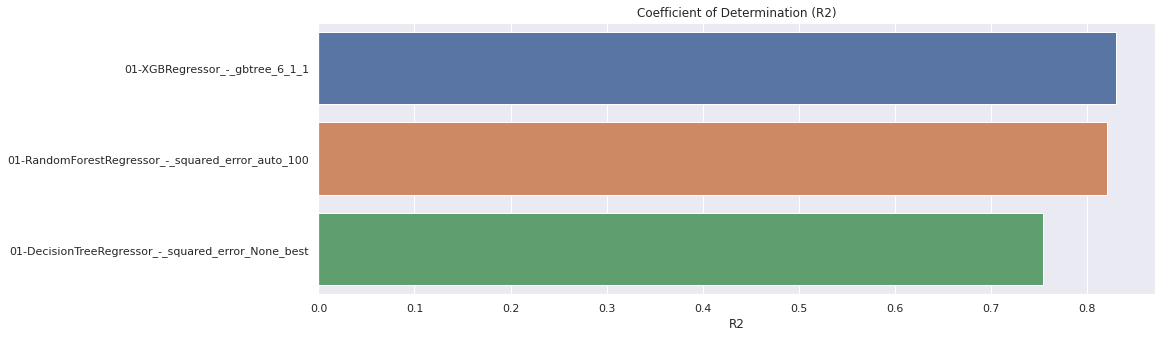

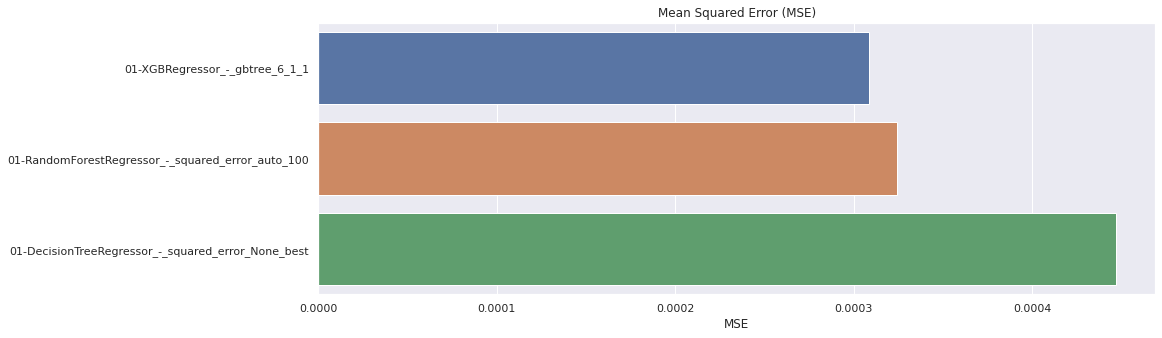

In [ ]:
for metrics_file in glob.glob(exe01_tables_path+ "/**/*.csv", recursive=True):
    reg_metrics_df = pd.read_csv(metrics_file, index_col=0)

    display(reg_metrics_df)
    
    sns.barplot(data=reg_metrics_df, x = "R2", y = reg_metrics_df.index)
    plt.title("Coefficient of Determination (R2)")
    plt.savefig(os.path.join(exe02_plots_path+"-R2_metrics.png"))
    plt.show()
    
    sns.barplot(data=reg_metrics_df.sort_values(by=["MSE"]), x = "MSE", y = reg_metrics_df.sort_values(by=["MSE"]).index)
    plt.title("Mean Squared Error (MSE)")
    plt.savefig(os.path.join(exe02_plots_path+"-MSE_metrics.png"))
    plt.show()

# Exercise 3: 
  - Train them using the different parameters they support

We create the directory in which we will save the results.

In [ ]:
mk_dir("exe03")
exe03_models_path = mk_dir("exe03/exe03_models")
exe03_tables_path = mk_dir("exe03/exe03_tables")

Directory already existing: /content/drive/My Drive/Data_Science_amb_Python/Sprint12-Aprenentatge_Supervisat_Regressions/Supervitat_Regressio/exe03
Directory already existing: /content/drive/My Drive/Data_Science_amb_Python/Sprint12-Aprenentatge_Supervisat_Regressions/Supervitat_Regressio/exe03/exe03_models
Directory already existing: /content/drive/My Drive/Data_Science_amb_Python/Sprint12-Aprenentatge_Supervisat_Regressions/Supervitat_Regressio/exe03/exe03_tables


We will use GridSearch to train the models with different parameters.

## GSCV_DecisionTreeRegressor

We will train the "DecisionTreeRegressor" with the different options of the following three parameters:
- **criterion** (The function to measure the quality of a split):
    - squared_error
    - friedman_mse
    - absolute_error
    - poisson
- **splitter** (The strategy used to choose the split at each node)
    - best
    - random
- **max_features** (The number of features to consider when looking for the best split):
    - sqrt
    - log2

1.   First we define the estimator that we will use in the search for parameters.

1.   Create a dictionary with parameters names as keys and lists of parameter settings to try as values.

1.   Then we define the name of the GridSearchCV object, the name of the file where the search result is saved and the path of the file.

1.   If the GridSearchCV has already been trained and saved, that is, if the file already exists, it is read.

1.   If it has not been previously trained, we define the GridSearchCV object with the estimator and the indicated parameters.

1.   Then it is trained, and saved to disk.

1.   Finally we tabulate the results and save the results in a csv file.
1.   In the last step we show the table with the results (they are not ordered)

In [ ]:
# Set estimator
DecisionTreeRegressor_model = DecisionTreeRegressor(random_state = 130)

# Set Hyperparameters 
param_grid = {"criterion":['squared_error', 'friedman_mse','absolute_error','poisson'],
              "splitter":['best','random'],
              "max_features":['sqrt', 'log2']}

# GridSearchCV name and filename
model_name = '{}-{}'.format("03", "GSCV_" + str(DecisionTreeRegressor_model).split("(")[0])
model_filename = model_name + ".sav"
model_filename_path = os.path.join(exe03_models_path, model_filename)

if os.path.isfile(model_filename_path):
    # load existing model
    print("\n{}: Loading model:\t{}".format(timenow(), model_filename))
    GSCV_DecisionTreeRegressor = pickle.load(open(model_filename_path, 'rb'))
else:
    # set GridSearchCV
    GSCV_DecisionTreeRegressor = GridSearchCV(DecisionTreeRegressor_model, param_grid, n_jobs = -1, verbose=3, cv = 2)
    print("\n{}: Start Fitting model:\t{}".format(timenow(), model_name))
    tiempo_inicio_fit = datetime.datetime.now()
    # Fit GridSearchCV
    GSCV_DecisionTreeRegressor.fit(X, y)
    print("\n{}: Finish. Fitting time:\t{}".format(timenow(), datetime.datetime.now() - tiempo_inicio_fit))
    # save the GridSearchCV to disk
    pickle.dump(GSCV_DecisionTreeRegressor, open(model_filename_path, 'wb'))

# Results filename
GSCV_results_filename = model_name + "_metrics.csv"
# Results dataframe
GSCV_DecisionTreeRegressor_results = pd.DataFrame(GSCV_DecisionTreeRegressor.cv_results_)
GSCV_DecisionTreeRegressor_results.index = model_name+'_-_'+GSCV_DecisionTreeRegressor_results['param_criterion']+'_'+GSCV_DecisionTreeRegressor_results['param_max_features']+'_'+GSCV_DecisionTreeRegressor_results['param_splitter']
GSCV_DecisionTreeRegressor_results.sort_values(by="rank_test_score", inplace=True)
cols = list(GSCV_DecisionTreeRegressor_results.columns)
cols.reverse()
GSCV_DecisionTreeRegressor_results = GSCV_DecisionTreeRegressor_results[cols]
# Results to file
print("\n{}: Save GSCV results in:\t{}".format(timenow(), GSCV_results_filename))
GSCV_DecisionTreeRegressor_results.to_csv(os.path.join(exe03_tables_path, GSCV_results_filename))
GSCV_DecisionTreeRegressor_results


04:18:16: Start Fitting model:	03-GSCV_DecisionTreeRegressor
Fitting 2 folds for each of 16 candidates, totalling 32 fits

04:18:29: Finish. Fitting time:	0:00:12.552012

04:18:29: Save GSCV results in:	03-GSCV_DecisionTreeRegressor_metrics.csv


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_features,param_splitter,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
03-GSCV_DecisionTreeRegressor_-_squared_error_sqrt_best,0.067933,0.002025,0.005298,9.155273e-04,squared_error,sqrt,best,"{'criterion': 'squared_error', 'max_features':...",0.171218,0.246004,0.208611,0.037393,1
03-GSCV_DecisionTreeRegressor_-_squared_error_sqrt_random,0.025422,0.001403,0.005040,6.986856e-04,squared_error,sqrt,random,"{'criterion': 'squared_error', 'max_features':...",0.038839,0.232164,0.135502,0.096662,11
03-GSCV_DecisionTreeRegressor_-_squared_error_log2_best,0.064246,0.002526,0.004483,2.232790e-04,squared_error,log2,best,"{'criterion': 'squared_error', 'max_features':...",0.171218,0.246004,0.208611,0.037393,1
03-GSCV_DecisionTreeRegressor_-_squared_error_log2_random,0.024936,0.001272,0.004692,5.960464e-07,squared_error,log2,random,"{'criterion': 'squared_error', 'max_features':...",0.038839,0.232164,0.135502,0.096662,11
03-GSCV_DecisionTreeRegressor_-_friedman_mse_sqrt_best,0.076144,0.000508,0.004954,4.416704e-04,friedman_mse,sqrt,best,"{'criterion': 'friedman_mse', 'max_features': ...",0.262796,0.147426,0.205111,0.057685,5
03-GSCV_DecisionTreeRegressor_-_friedman_mse_sqrt_random,0.023357,0.000196,0.004618,3.771782e-04,friedman_mse,sqrt,random,"{'criterion': 'friedman_mse', 'max_features': ...",0.167859,0.211641,0.189750,0.021891,7
03-GSCV_DecisionTreeRegressor_-_friedman_mse_log2_best,0.066401,0.000129,0.006499,2.203226e-03,friedman_mse,log2,best,"{'criterion': 'friedman_mse', 'max_features': ...",0.262796,0.147426,0.205111,0.057685,5
03-GSCV_DecisionTreeRegressor_-_friedman_mse_log2_random,0.023097,0.000280,0.004255,1.275539e-04,friedman_mse,log2,random,"{'criterion': 'friedman_mse', 'max_features': ...",0.167859,0.211641,0.189750,0.021891,7
03-GSCV_DecisionTreeRegressor_-_absolute_error_sqrt_best,2.801534,0.253981,0.004657,2.033710e-04,absolute_error,sqrt,best,"{'criterion': 'absolute_error', 'max_features'...",0.170931,0.239852,0.205392,0.034460,3
03-GSCV_DecisionTreeRegressor_-_absolute_error_sqrt_random,2.266015,0.186350,0.004438,4.136562e-05,absolute_error,sqrt,random,"{'criterion': 'absolute_error', 'max_features'...",0.138928,0.194154,0.166541,0.027613,9


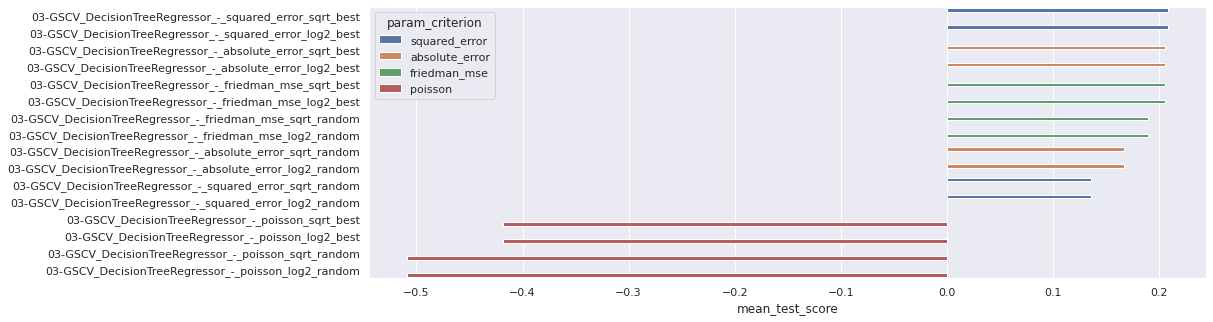

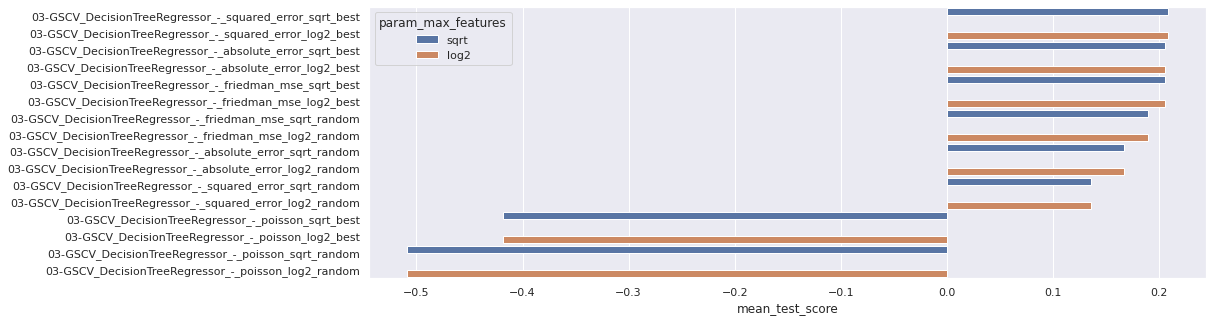

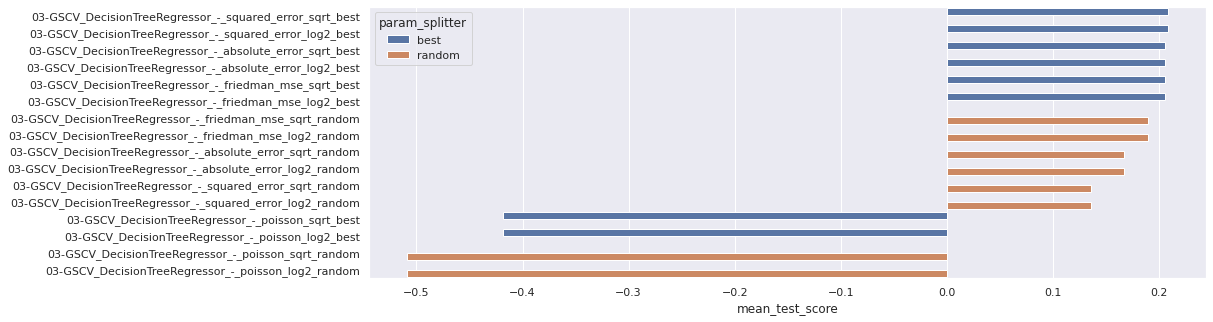

In [ ]:
sns.barplot(data=GSCV_DecisionTreeRegressor_results, x="mean_test_score", y=GSCV_DecisionTreeRegressor_results.index, hue="param_criterion")
plt.show()
sns.barplot(data=GSCV_DecisionTreeRegressor_results, x="mean_test_score", y=GSCV_DecisionTreeRegressor_results.index, hue="param_max_features")
plt.show()
sns.barplot(data=GSCV_DecisionTreeRegressor_results, x="mean_test_score", y=GSCV_DecisionTreeRegressor_results.index, hue="param_splitter")
plt.show()

We can see that the parameter **criterion** is the one that has the greatest effect on the results.


## GSCV_XGBRegressor

We will train the "XGBRegressor" with the different options of the following four parameters:
- **max_depth** (Maximum tree depth for base learners.):
    - 5
    - 6
- **booster** (Specify which booster to use)
    - gbtree
    - gblinear
- **min_child_weight** (Minimum sum of instance weight(hessian) needed in a child):
    - 1
    - 2
- **subsample** (Subsample ratio of the training instance)
    - 0.5
    - 1

In [ ]:
# Set estimator
XGBRegressor_model = XGBRegressor(random_state = 130, verbosity=2, n_jobs = -1)

# Set Hyperparameters 
param_grid = {'max_depth': [5, 6],
              'booster':['gbtree','gblinear'], 
              'min_child_weight': [1, 2], 
              'subsample': [0.5, 1]}
# GridSearchCV name and filename
model_name = '{}-{}'.format("03", "GSCV_" + str(XGBRegressor_model).split("(")[0])
model_filename = model_name + ".sav"
model_filename_path = os.path.join(exe03_models_path, model_filename)

if os.path.isfile(model_filename_path):
    # load existing model
    print("\n{}: Loading model:\t{}".format(timenow(), model_filename))
    GSCV_XGBRegressor = pickle.load(open(model_filename_path, 'rb'))
else:
    # set GridSearchCV
    GSCV_XGBRegressor = GridSearchCV(XGBRegressor_model, param_grid, n_jobs = -1, verbose=3, cv =2)
    print("\n{}: Start Fitting model:\t{}".format(timenow(), model_name))
    tiempo_inicio_fit = datetime.datetime.now()
    # Fit GridSearchCV
    GSCV_XGBRegressor.fit(X, y)
    print("\n{}: Finish. Fitting time:\t{}".format(timenow(), datetime.datetime.now() - tiempo_inicio_fit))
    # save the GridSearchCV to disk
    pickle.dump(GSCV_XGBRegressor, open(model_filename_path, 'wb'))

# Results filename
GSCV_results_filename = model_name + "_metrics.csv"
# Results dataframe
GSCV_XGBRegressor_results = pd.DataFrame(GSCV_XGBRegressor.cv_results_)
GSCV_XGBRegressor_results.index = model_name+'_-_'+GSCV_XGBRegressor_results['param_booster']+'_'+GSCV_XGBRegressor_results['param_max_depth'].astype(str)+'_'+GSCV_XGBRegressor_results['param_min_child_weight'].astype(str)+'_'+GSCV_XGBRegressor_results['param_subsample'].astype(str)
GSCV_XGBRegressor_results.sort_values(by="rank_test_score", inplace=True)
cols = list(GSCV_XGBRegressor_results.columns)
cols.reverse()
GSCV_XGBRegressor_results = GSCV_XGBRegressor_results[cols]
# Results to file
print("\n{}: Save GSCV results in:\t{}".format(timenow(), GSCV_results_filename))
GSCV_XGBRegressor_results.to_csv(os.path.join(exe03_tables_path, GSCV_results_filename))
GSCV_XGBRegressor_results


04:18:29: Start Fitting model:	03-GSCV_XGBRegressor
Fitting 2 folds for each of 16 candidates, totalling 32 fits
[04:21:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[04:21:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[04:21:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[04:21:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[04:21:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[04:21:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[04:21:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[04:21:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned n

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_booster,param_max_depth,param_min_child_weight,param_subsample,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
03-GSCV_XGBRegressor_-_gbtree_5_1_0.5,16.160875,0.185823,0.031853,0.000118,gbtree,5,1,0.5,"{'booster': 'gbtree', 'max_depth': 5, 'min_chi...",0.894085,0.875225,0.884655,0.009430,8
03-GSCV_XGBRegressor_-_gbtree_5_1_1,15.842257,0.567974,0.043522,0.003511,gbtree,5,1,1,"{'booster': 'gbtree', 'max_depth': 5, 'min_chi...",0.919280,0.905430,0.912355,0.006925,2
03-GSCV_XGBRegressor_-_gbtree_5_2_0.5,36.868763,0.537359,0.043927,0.002960,gbtree,5,2,0.5,"{'booster': 'gbtree', 'max_depth': 5, 'min_chi...",0.899157,0.875731,0.887444,0.011713,7
03-GSCV_XGBRegressor_-_gbtree_5_2_1,18.187062,0.211389,0.040869,0.000834,gbtree,5,2,1,"{'booster': 'gbtree', 'max_depth': 5, 'min_chi...",0.927680,0.905408,0.916544,0.011136,1
03-GSCV_XGBRegressor_-_gbtree_6_1_0.5,20.987533,0.094764,0.049933,0.010334,gbtree,6,1,0.5,"{'booster': 'gbtree', 'max_depth': 6, 'min_chi...",0.907824,0.893386,0.900605,0.007219,6
03-GSCV_XGBRegressor_-_gbtree_6_1_1,20.651758,0.881562,0.048198,0.010883,gbtree,6,1,1,"{'booster': 'gbtree', 'max_depth': 6, 'min_chi...",0.917770,0.895490,0.906630,0.011140,4
03-GSCV_XGBRegressor_-_gbtree_6_2_0.5,25.059819,0.795721,0.057163,0.005064,gbtree,6,2,0.5,"{'booster': 'gbtree', 'max_depth': 6, 'min_chi...",0.912648,0.889325,0.900987,0.011661,5
03-GSCV_XGBRegressor_-_gbtree_6_2_1,6.533950,1.313375,0.053540,0.000114,gbtree,6,2,1,"{'booster': 'gbtree', 'max_depth': 6, 'min_chi...",0.915822,0.901366,0.908594,0.007228,3
03-GSCV_XGBRegressor_-_gblinear_5_1_0.5,5.692531,0.055300,0.041010,0.007887,gblinear,5,1,0.5,"{'booster': 'gblinear', 'max_depth': 5, 'min_c...",0.139102,0.133012,0.136057,0.003045,15
03-GSCV_XGBRegressor_-_gblinear_5_1_1,5.417336,0.561080,0.038038,0.019862,gblinear,5,1,1,"{'booster': 'gblinear', 'max_depth': 5, 'min_c...",0.137617,0.135922,0.136770,0.000847,14


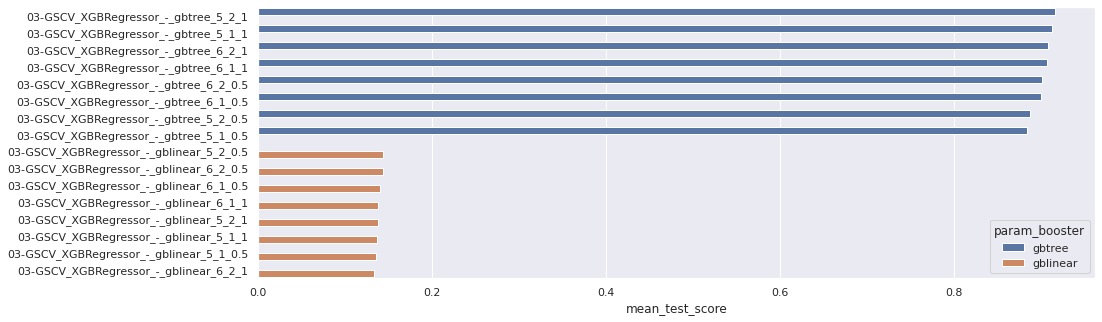

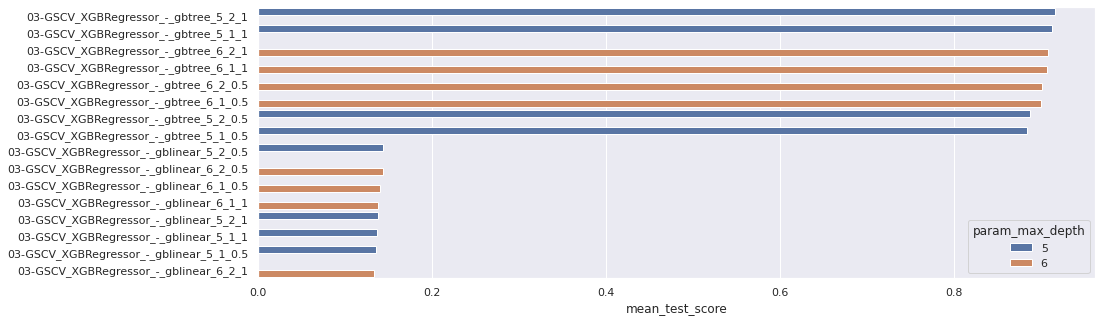

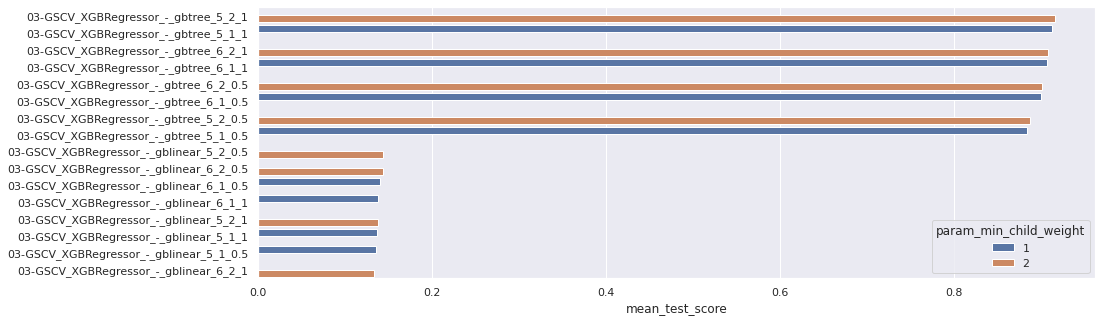

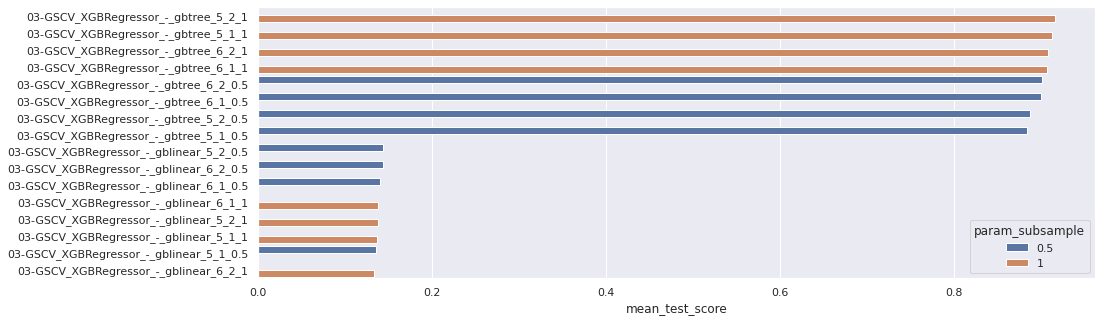

In [ ]:
sns.barplot(data=GSCV_XGBRegressor_results, x="mean_test_score", y=GSCV_XGBRegressor_results.index, hue="param_booster")
plt.show()
sns.barplot(data=GSCV_XGBRegressor_results, x="mean_test_score", y=GSCV_XGBRegressor_results.index, hue="param_max_depth")
plt.show()
sns.barplot(data=GSCV_XGBRegressor_results, x="mean_test_score", y=GSCV_XGBRegressor_results.index, hue="param_min_child_weight")
plt.show()
sns.barplot(data=GSCV_XGBRegressor_results, x="mean_test_score", y=GSCV_XGBRegressor_results.index, hue="param_subsample")
plt.show()

We can see that the parameter **booster** is the one that has the greatest effect on the results.

## GSCV_RandomForestRegressor

We will train the "RandomForestRegressor" with the different options of the following three parameters:
- **criterion** (The function to measure the quality of a split):
    - squared_error
    - absolute_error
    - poisson
- **n_estimators** (The number of trees in the forest.)
    - 50
    - 150
- **max_features** (The number of features to consider when looking for the best split):
    - auto
    - None

In [ ]:
# Set estimator
RandomForestRegressor_model = RandomForestRegressor(random_state=130, verbose=3, n_jobs = -1)

# Set Hyperparameters 
param_grid = {"n_estimators":[50, 150], 
              "criterion":['squared_error','absolute_error', "poisson"], 
              "max_features":['auto', None]}

# GridSearchCV name and filename
model_name = '{}-{}'.format("03", "GSCV_" + str(RandomForestRegressor_model).split("(")[0])
model_filename = model_name + ".sav"
model_filename_path = os.path.join(exe03_models_path, model_filename)

if os.path.isfile(model_filename_path):
    # load existing model
    print("\n{}: Loading model:\t{}".format(timenow(), model_filename))
    GSCV_RandomForestRegressor = pickle.load(open(model_filename_path, 'rb'))
else:
    # set GridSearchCV
    GSCV_RandomForestRegressor = GridSearchCV(RandomForestRegressor_model, param_grid, n_jobs = -1, verbose=3, cv = 2)
    print("\n{}: Start Fitting model:\t{}".format(timenow(), model_name))
    tiempo_inicio_fit = datetime.datetime.now()
    # Fit GridSearchCV
    GSCV_RandomForestRegressor.fit(X, y)
    print("\n{}: Finish. Fitting time:\t{}".format(timenow(), datetime.datetime.now() - tiempo_inicio_fit))
    # save the GridSearchCV to disk
    pickle.dump(GSCV_RandomForestRegressor, open(model_filename_path, 'wb'))

# Results filename
GSCV_results_filename = model_name + "_metrics.csv"
# Results dataframe
GSCV_RandomForestRegressor_results = pd.DataFrame(GSCV_RandomForestRegressor.cv_results_)
GSCV_RandomForestRegressor_results.index = model_name+'_-_'+GSCV_RandomForestRegressor_results['param_criterion']+'_'+GSCV_RandomForestRegressor_results['param_max_features'].astype(str)+'_'+GSCV_RandomForestRegressor_results['param_n_estimators'].astype(str)
GSCV_RandomForestRegressor_results.fillna("none", inplace=True)
GSCV_RandomForestRegressor_results.sort_values(by="rank_test_score", inplace=True)
cols = list(GSCV_RandomForestRegressor_results.columns)
cols.reverse()
GSCV_RandomForestRegressor_results = GSCV_RandomForestRegressor_results[cols]
# Results to file
print("\n{}: Save GSCV results in:\t{}".format(timenow(), GSCV_results_filename))
GSCV_RandomForestRegressor_results.to_csv(os.path.join(exe03_tables_path, GSCV_results_filename))
GSCV_RandomForestRegressor_results


04:21:48: Start Fitting model:	03-GSCV_RandomForestRegressor
Fitting 2 folds for each of 12 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 150building tree 2 of 150

building tree 3 of 150
building tree 4 of 150
building tree 5 of 150
building tree 6 of 150
building tree 7 of 150
building tree 8 of 150
building tree 9 of 150
building tree 10 of 150
building tree 11 of 150
building tree 12 of 150
building tree 13 of 150
building tree 14 of 150
building tree 15 of 150
building tree 16 of 150
building tree 17 of 150
building tree 18 of 150
building tree 19 of 150
building tree 20 of 150
building tree 21 of 150
building tree 22 of 150
building tree 23 of 150
building tree 24 of 150
building tree 25 of 150
building tree 26 of 150
building tree 27 of 150
building tree 28 of 150
building tree 29 of 150
building tree 30 of 150


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    4.0s


building tree 31 of 150
building tree 32 of 150
building tree 33 of 150
building tree 34 of 150
building tree 35 of 150
building tree 36 of 150
building tree 37 of 150
building tree 38 of 150
building tree 39 of 150
building tree 40 of 150
building tree 41 of 150
building tree 42 of 150
building tree 43 of 150
building tree 44 of 150
building tree 45 of 150
building tree 46 of 150
building tree 47 of 150
building tree 48 of 150
building tree 49 of 150
building tree 50 of 150
building tree 51 of 150
building tree 52 of 150
building tree 53 of 150
building tree 54 of 150
building tree 55 of 150
building tree 56 of 150
building tree 57 of 150
building tree 58 of 150
building tree 59 of 150
building tree 60 of 150
building tree 61 of 150
building tree 62 of 150
building tree 63 of 150
building tree 64 of 150
building tree 65 of 150
building tree 66 of 150
building tree 67 of 150
building tree 68 of 150
building tree 69 of 150
building tree 70 of 150
building tree 71 of 150
building tree 72

[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   17.5s


building tree 127 of 150
building tree 128 of 150
building tree 129 of 150
building tree 130 of 150
building tree 131 of 150
building tree 132 of 150
building tree 133 of 150
building tree 134 of 150
building tree 135 of 150
building tree 136 of 150
building tree 137 of 150
building tree 138 of 150
building tree 139 of 150
building tree 140 of 150
building tree 141 of 150
building tree 142 of 150
building tree 143 of 150
building tree 144 of 150
building tree 145 of 150
building tree 146 of 150
building tree 147 of 150
building tree 148 of 150
building tree 149 of 150
building tree 150 of 150


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   21.1s finished



05:03:36: Finish. Fitting time:	0:41:48.448041

05:03:37: Save GSCV results in:	03-GSCV_RandomForestRegressor_metrics.csv


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
03-GSCV_RandomForestRegressor_-_squared_error_auto_50,6.910640,0.046886,0.152653,0.050006,squared_error,auto,50,"{'criterion': 'squared_error', 'max_features':...",0.875587,0.840636,0.858111,0.017476,3
03-GSCV_RandomForestRegressor_-_squared_error_auto_150,20.229082,0.023517,0.467914,0.046486,squared_error,auto,150,"{'criterion': 'squared_error', 'max_features':...",0.880396,0.853488,0.866942,0.013454,1
03-GSCV_RandomForestRegressor_-_squared_error_None_50,6.728754,0.032665,0.209086,0.006407,squared_error,None,50,"{'criterion': 'squared_error', 'max_features':...",0.875587,0.840636,0.858111,0.017476,3
03-GSCV_RandomForestRegressor_-_squared_error_None_150,20.210302,0.039741,0.471786,0.043998,squared_error,None,150,"{'criterion': 'squared_error', 'max_features':...",0.880396,0.853488,0.866942,0.013454,1
03-GSCV_RandomForestRegressor_-_absolute_error_auto_50,273.151297,3.851167,0.221759,0.000699,absolute_error,auto,50,"{'criterion': 'absolute_error', 'max_features'...",0.811185,0.792792,0.801989,0.009196,7
03-GSCV_RandomForestRegressor_-_absolute_error_auto_150,817.976916,5.607327,0.622461,0.000425,absolute_error,auto,150,"{'criterion': 'absolute_error', 'max_features'...",0.823104,0.787467,0.805285,0.017818,5
03-GSCV_RandomForestRegressor_-_absolute_error_None_50,272.164208,4.866048,0.222192,0.001084,absolute_error,None,50,"{'criterion': 'absolute_error', 'max_features'...",0.811185,0.792792,0.801989,0.009196,7
03-GSCV_RandomForestRegressor_-_absolute_error_None_150,816.795889,4.373243,0.581869,0.054215,absolute_error,None,150,"{'criterion': 'absolute_error', 'max_features'...",0.823104,0.787467,0.805285,0.017818,5
03-GSCV_RandomForestRegressor_-_poisson_auto_50,29.933674,0.099462,0.377277,0.054758,poisson,auto,50,"{'criterion': 'poisson', 'max_features': 'auto...",0.328651,0.369345,0.348998,0.020347,9
03-GSCV_RandomForestRegressor_-_poisson_auto_150,92.974410,1.920648,0.927096,0.003797,poisson,auto,150,"{'criterion': 'poisson', 'max_features': 'auto...",0.315879,0.368766,0.342322,0.026444,11


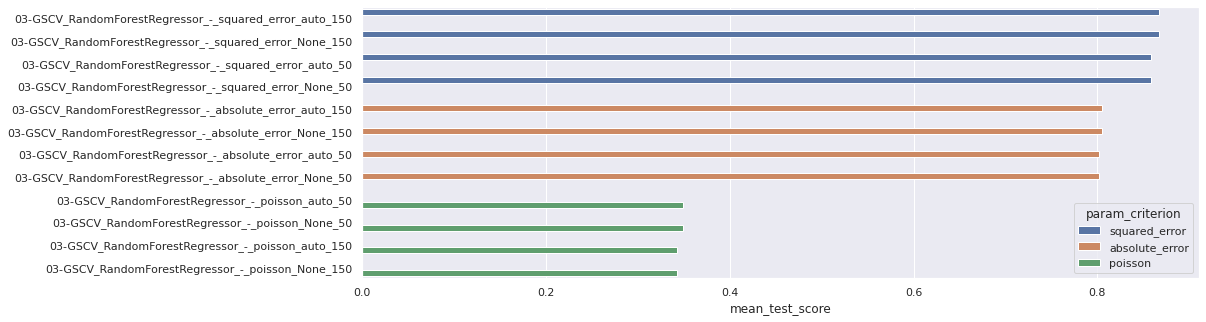

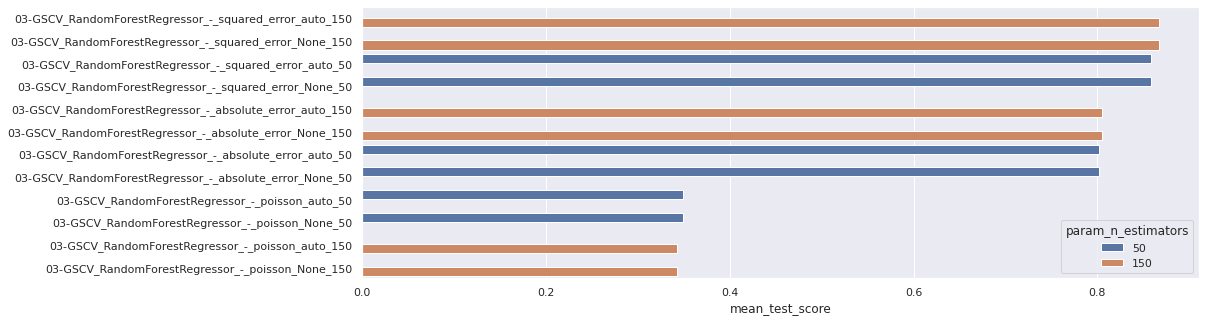

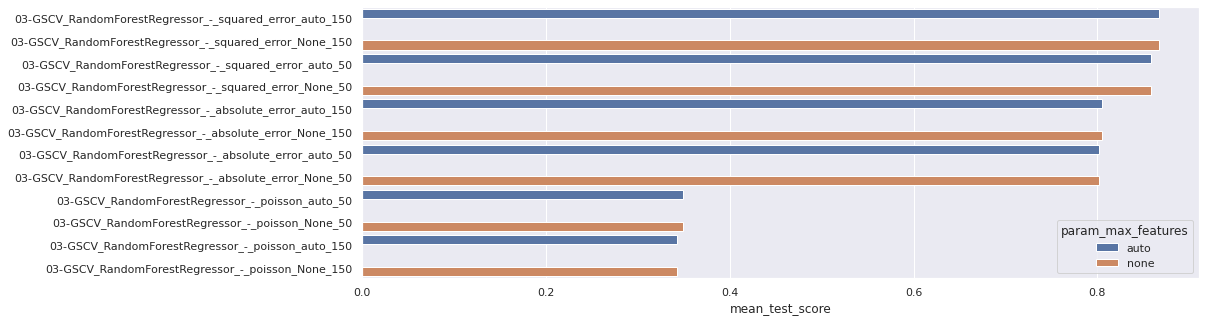

In [ ]:
sns.barplot(data=GSCV_RandomForestRegressor_results, x="mean_test_score", y=GSCV_RandomForestRegressor_results.index, hue="param_criterion")
plt.show()
sns.barplot(data=GSCV_RandomForestRegressor_results, x="mean_test_score", y=GSCV_RandomForestRegressor_results.index, hue="param_n_estimators")
plt.show()
sns.barplot(data=GSCV_RandomForestRegressor_results, x="mean_test_score", y=GSCV_RandomForestRegressor_results.index, hue="param_max_features")
plt.show()

We can see that the parameter **criterion** is the one that has the greatest effect on the results.


## Summary exercise 3

In a similar way to the exercise 2, we read the results of each GridSearchCV and append them in a single table. Then we order them by the R2 value in ascending order and finally we show the table and and plot them.

Directory already existing: /content/drive/My Drive/Data_Science_amb_Python/Sprint12-Aprenentatge_Supervisat_Regressions/Supervitat_Regressio/exe03/exe03_tables


,mean_test_score
03-GSCV_XGBRegressor_-_gbtree_5_2_1,0.916544
03-GSCV_XGBRegressor_-_gbtree_5_1_1,0.912355
03-GSCV_XGBRegressor_-_gbtree_6_2_1,0.908594
03-GSCV_XGBRegressor_-_gbtree_6_1_1,0.906630
03-GSCV_XGBRegressor_-_gbtree_6_2_0.5,0.900987
03-GSCV_XGBRegressor_-_gbtree_6_1_0.5,0.900605
03-GSCV_XGBRegressor_-_gbtree_5_2_0.5,0.887444
03-GSCV_XGBRegressor_-_gbtree_5_1_0.5,0.884655
03-GSCV_RandomForestRegressor_-_squared_error_auto_150,0.866942
03-GSCV_RandomForestRegressor_-_squared_error_None_150,0.866942


<AxesSubplot:xlabel='mean_test_score'>

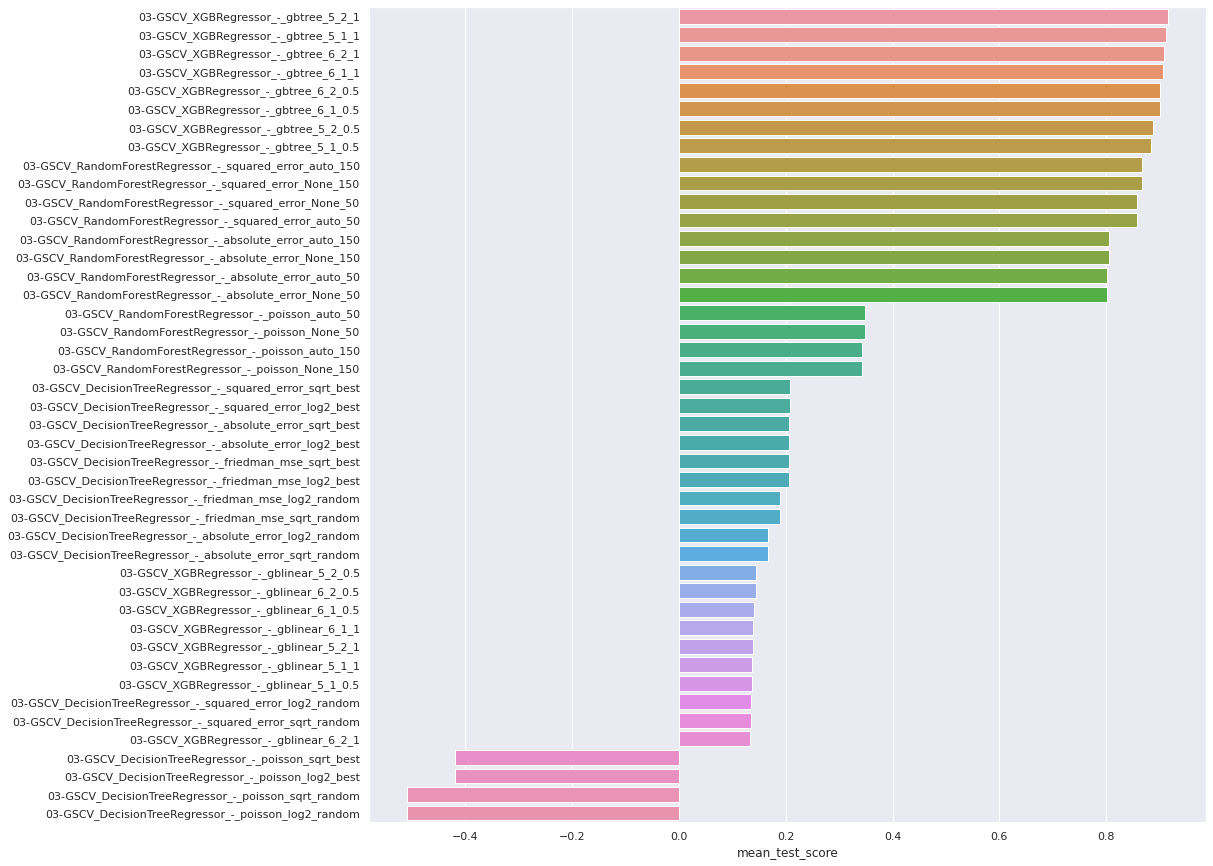

In [ ]:
exe03_tables_path = mk_dir("exe03/exe03_tables")
metrics_lst = []
for GSCV_results_filename in os.listdir(exe03_tables_path):
    GSCV_results_df = pd.read_csv(os.path.join(exe03_tables_path,GSCV_results_filename), index_col=0)
    metrics_lst.append(GSCV_results_df[["mean_test_score"]])
all_metrics_df = pd.concat(metrics_lst)
all_metrics_df.sort_values(by=["mean_test_score"], ascending=[False], inplace=True)
display(all_metrics_df)
plt.figure(figsize = (15,15))
sns.barplot(data=all_metrics_df, x = "mean_test_score", y = all_metrics_df.index)

The best results were obtained by the XGBRegressor estimator with the following parameters:
- booster: gbtree
- max_depth: 5
- min_child_weight: 2
- subsample: 1 

# Exercise 4: 
  - Compare your performance using the train / test approach or using all data (internal validation)

We create the directory in which we will save the results.

In [ ]:
mk_dir("exe04")
exe04_plots_path = mk_dir("exe04/exe04_plots")
exe04_tables_path = mk_dir("exe04/exe04_tables")

Directory already existing: /content/drive/My Drive/Data_Science_amb_Python/Sprint12-Aprenentatge_Supervisat_Regressions/Supervitat_Regressio/exe04
Directory already existing: /content/drive/My Drive/Data_Science_amb_Python/Sprint12-Aprenentatge_Supervisat_Regressions/Supervitat_Regressio/exe04/exe04_plots
Directory already existing: /content/drive/My Drive/Data_Science_amb_Python/Sprint12-Aprenentatge_Supervisat_Regressions/Supervitat_Regressio/exe04/exe04_tables


## Train Test approach

We read the results from the exercise 1

,R2,MSE,MAE,MAPE,EV,ME,MedAE
01-XGBRegressor_-_gbtree_6_1_1,0.82995,0.00031,0.00512,0.07203,0.83009,0.96974,0.00311
01-RandomForestRegressor_-_squared_error_auto_100,0.82121,0.00032,0.00331,0.04321,0.82136,0.97221,0.00091
01-DecisionTreeRegressor_-_squared_error_None_best,0.75385,0.00045,0.00518,0.06384,0.75401,0.98440,0.00213


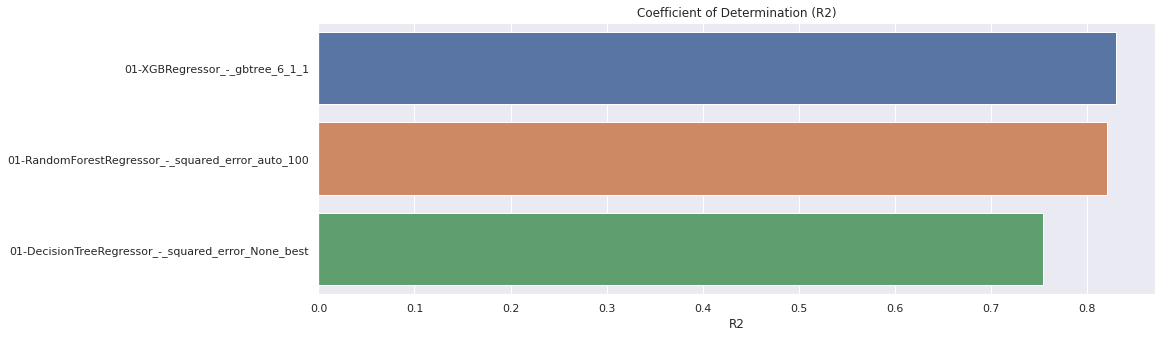

In [ ]:
reg_metrics_df = pd.read_csv(os.path.join(exe01_tables_path, "01-regressors_metrics.csv"), index_col=0)
display(reg_metrics_df.round(5))
sns.barplot(data=reg_metrics_df, x = "R2", y = reg_metrics_df.index)
plt.title("Coefficient of Determination (R2)")
plt.show()

## k-Fold Cross-Validation (internal validation)

Provides train/test indices to split data in train/test sets. Split dataset into k consecutive folds.

Each fold is then used once as a validation while the k-1 remaining folds form the training set.

We will be increasing the K from 2 to 12 to see the effect on the results.

In [ ]:
max_splits = 13
n_splits = range(2,max_splits)
kfcv_filename = 'kfcv_{}'.format(max_splits)
kfcv_filename_path = os.path.join(exe04_tables_path, kfcv_filename)

if os.path.isfile(kfcv_filename_path+".pkl"):
    # load existing model
    print("\n{}: loading k-Fold Cross-Validation Scores:\t{}".format(timenow(), kfcv_filename))
    kfcv_df = pd.read_csv(kfcv_filename_path+".csv", index_col=0)
    kfcv_file = open(kfcv_filename_path+".pkl", "rb")
    model_kfcv_results = pickle.load(kfcv_file)
    kfcv_means_df = pd.DataFrame(index=model_kfcv_results.keys(), columns=n_splits)
    for model_str, kfcv_results in model_kfcv_results.items():
        print("\n{}: Model: {}".format(timenow(), model_str))
        for score in kfcv_results:
            print("{}:\tN splits: {}".format(timenow(),len(score)))
            print("{}:\t\tR2 scores:\t{}\n\t\t\tMean (std):\t{:.6f} ({:.6f})".format(timenow(),score, np.mean(score), sem(score)))
            kfcv_means_df.loc[model_str,len(score)] = np.mean(score)
        plt.boxplot(kfcv_results, showmeans=True, labels=n_splits)
        plt.xlabel("Nº splits")
        plt.ylabel("R2 score")
        plt.title(model_str, fontweight = "bold")
        filename = model_str+"-K-fold_cv.png"
        plt.savefig(os.path.join(exe04_plots_path, filename))
        plt.show()
else:    
    model_kfcv_results = dict()
    for model in regression_models:
        model_str = str(model).split("(")[0]
        print("\n{}: Model: {}".format(timenow(), model_str))
        kfcv_results = list()
        for n_s in n_splits:
            print("{}:\tN splits: {}".format(timenow(),n_s))
            # evaluate using a given number of repeats
            scores = kfcv_evaluator(X, y,model, n_s)
            # summarize
            print("{}:\t\tR2 scores:\t{}\n\t\t\tMean (std):\t{:.6f} ({:.6f})".format(timenow(),scores, np.mean(scores), sem(scores)))
            # store
            kfcv_results.append(scores)
        model_kfcv_results[model_str] = kfcv_results

        kfcv_means_df = pd.DataFrame(index=model_kfcv_results.keys(), columns=n_splits)
        for model_str, kfcv_results in model_kfcv_results.items():
            for score in kfcv_results:
                kfcv_means_df.loc[model_str,len(score)] = np.mean(score)
        kfcv_means_df.to_csv(kfcv_filename_path+"_means.csv")

        plt.boxplot(kfcv_results, showmeans=True, labels=n_splits)
        plt.xlabel("Nº splits")
        plt.ylabel("R2 score")
        plt.title(model_str, fontweight = "bold")
        
        filename = model_str+"-K-fold_cv.png"
        plt.savefig(os.path.join(exe04_plots_path, filename))
        plt.show()
    
    kfcv_file = open(kfcv_filename_path+".pkl", "wb")
    pickle.dump(model_kfcv_results, kfcv_file)
    kfcv_file.close()

    kfcv_df = pd.DataFrame.from_dict(model_kfcv_results, orient='index', columns=n_splits)
    kfcv_df.to_csv(kfcv_filename_path+".csv")

display(kfcv_df)
display(kfcv_means_df)

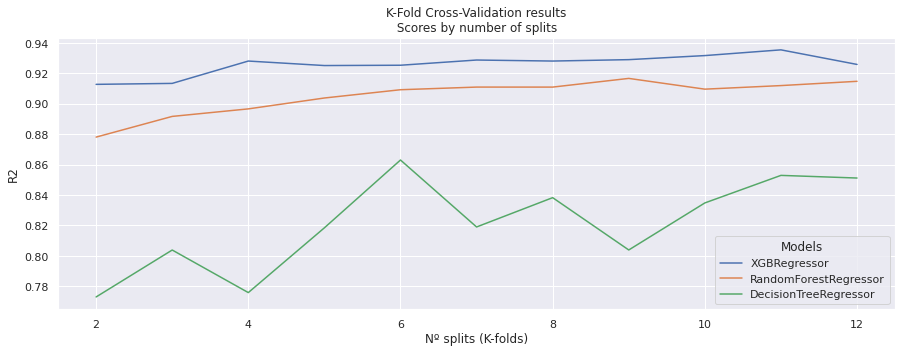

In [ ]:

plt.plot(kfcv_means_df.loc["XGBRegressor"], label = "XGBRegressor")
plt.plot(kfcv_means_df.loc["RandomForestRegressor"], label = "RandomForestRegressor")
plt.plot(kfcv_means_df.loc["DecisionTreeRegressor"], label = "DecisionTreeRegressor")
plt.xlabel("Nº splits (K-folds)")
plt.ylabel("R2")
plt.title("K-Fold Cross-Validation results\n Scores by number of splits ")
plt.legend(title="Models")
plt.show()

We find that by means of this internal validation method we do obtain better results than by train test approach.

We see that increasing the number of k has a positive effect.

## Repeated k-Fold Cross-Validation (internal validation)


Repeats K-Fold n times with different randomization in each repetition.



We will be increasing the K from 2 to 7   and the number or repetitions to see the effect on the results.


00:56:54: Model: DecisionTreeRegressor

00:56:54: loading Repeated k-Fold Cross-Validation Scores:	/content/drive/My Drive/Data_Science_amb_Python/Sprint12-Aprenentatge_Supervisat_Regressions/Supervitat_Regressio/exe04/exe04_tables/rkfcv_7_7-DecisionTreeRegressor.sav

00:56:54: Model: RandomForestRegressor

00:56:54: loading Repeated k-Fold Cross-Validation Scores:	/content/drive/My Drive/Data_Science_amb_Python/Sprint12-Aprenentatge_Supervisat_Regressions/Supervitat_Regressio/exe04/exe04_tables/rkfcv_7_7-RandomForestRegressor.sav

00:56:54: Model: XGBRegressor

00:56:54: loading Repeated k-Fold Cross-Validation Scores:	/content/drive/My Drive/Data_Science_amb_Python/Sprint12-Aprenentatge_Supervisat_Regressions/Supervitat_Regressio/exe04/exe04_tables/rkfcv_7_7-XGBRegressor.sav


,model,n_splits,1,2,3,4,5,6
0,DecisionTreeRegressor,2,"[0.7900799108131242, 0.755877429731078]","[0.7900799108131242, 0.755877429731078, 0.7460...","[0.7900799108131242, 0.755877429731078, 0.7460...","[0.7900799108131242, 0.755877429731078, 0.7460...","[0.7900799108131242, 0.755877429731078, 0.7460...","[0.7900799108131242, 0.755877429731078, 0.7460..."
1,DecisionTreeRegressor,3,"[0.7128169151452322, 0.8413953610525562, 0.857...","[0.7128169151452322, 0.8413953610525562, 0.857...","[0.7128169151452322, 0.8413953610525562, 0.857...","[0.7128169151452322, 0.8413953610525562, 0.857...","[0.7128169151452322, 0.8413953610525562, 0.857...","[0.7128169151452322, 0.8413953610525562, 0.857..."
2,DecisionTreeRegressor,4,"[0.7885629219399365, 0.7744701412072565, 0.712...","[0.7885629219399365, 0.7744701412072565, 0.712...","[0.7885629219399365, 0.7744701412072565, 0.712...","[0.7885629219399365, 0.7744701412072565, 0.712...","[0.7885629219399365, 0.7744701412072565, 0.712...","[0.7885629219399365, 0.7744701412072565, 0.712..."
3,DecisionTreeRegressor,5,"[0.7163372704622235, 0.8361435465973017, 0.874...","[0.7163372704622235, 0.8361435465973017, 0.874...","[0.7163372704622235, 0.8361435465973017, 0.874...","[0.7163372704622235, 0.8361435465973017, 0.874...","[0.7163372704622235, 0.8361435465973017, 0.874...","[0.7163372704622235, 0.8361435465973017, 0.874..."
4,DecisionTreeRegressor,6,"[0.7738294546137348, 0.846200000472402, 0.8537...","[0.7738294546137348, 0.846200000472402, 0.8537...","[0.7738294546137348, 0.846200000472402, 0.8537...","[0.7738294546137348, 0.846200000472402, 0.8537...","[0.7738294546137348, 0.846200000472402, 0.8537...","[0.7738294546137348, 0.846200000472402, 0.8537..."
5,RandomForestRegressor,2,"[0.8516038641033704, 0.9045849522187442]","[0.8516038641033704, 0.9045849522187442, 0.866...","[0.8516038641033704, 0.9045849522187442, 0.866...","[0.8516038641033704, 0.9045849522187442, 0.866...","[0.8516038641033704, 0.9045849522187442, 0.866...","[0.8516038641033704, 0.9045849522187442, 0.866..."
6,RandomForestRegressor,3,"[0.8187477099770026, 0.9278644107543292, 0.928...","[0.8187477099770026, 0.9278644107543292, 0.928...","[0.8187477099770026, 0.9278644107543292, 0.928...","[0.8187477099770026, 0.9278644107543292, 0.928...","[0.8187477099770026, 0.9278644107543292, 0.928...","[0.8187477099770026, 0.9278644107543292, 0.928..."
7,RandomForestRegressor,4,"[0.8206891965714999, 0.9099055206923343, 0.907...","[0.8206891965714999, 0.9099055206923343, 0.907...","[0.8206891965714999, 0.9099055206923343, 0.907...","[0.8206891965714999, 0.9099055206923343, 0.907...","[0.8206891965714999, 0.9099055206923343, 0.907...","[0.8206891965714999, 0.9099055206923343, 0.907..."
8,RandomForestRegressor,5,"[0.8032844842736688, 0.9072445609156169, 0.934...","[0.8032844842736688, 0.9072445609156169, 0.934...","[0.8032844842736688, 0.9072445609156169, 0.934...","[0.8032844842736688, 0.9072445609156169, 0.934...","[0.8032844842736688, 0.9072445609156169, 0.934...","[0.8032844842736688, 0.9072445609156169, 0.934..."
9,RandomForestRegressor,6,"[0.7869479878764678, 0.9032722337875689, 0.938...","[0.7869479878764678, 0.9032722337875689, 0.938...","[0.7869479878764678, 0.9032722337875689, 0.938...","[0.7869479878764679, 0.9032722337875689, 0.938...","[0.7869479878764678, 0.9032722337875689, 0.938...","[0.7869479878764679, 0.9032722337875689, 0.938..."


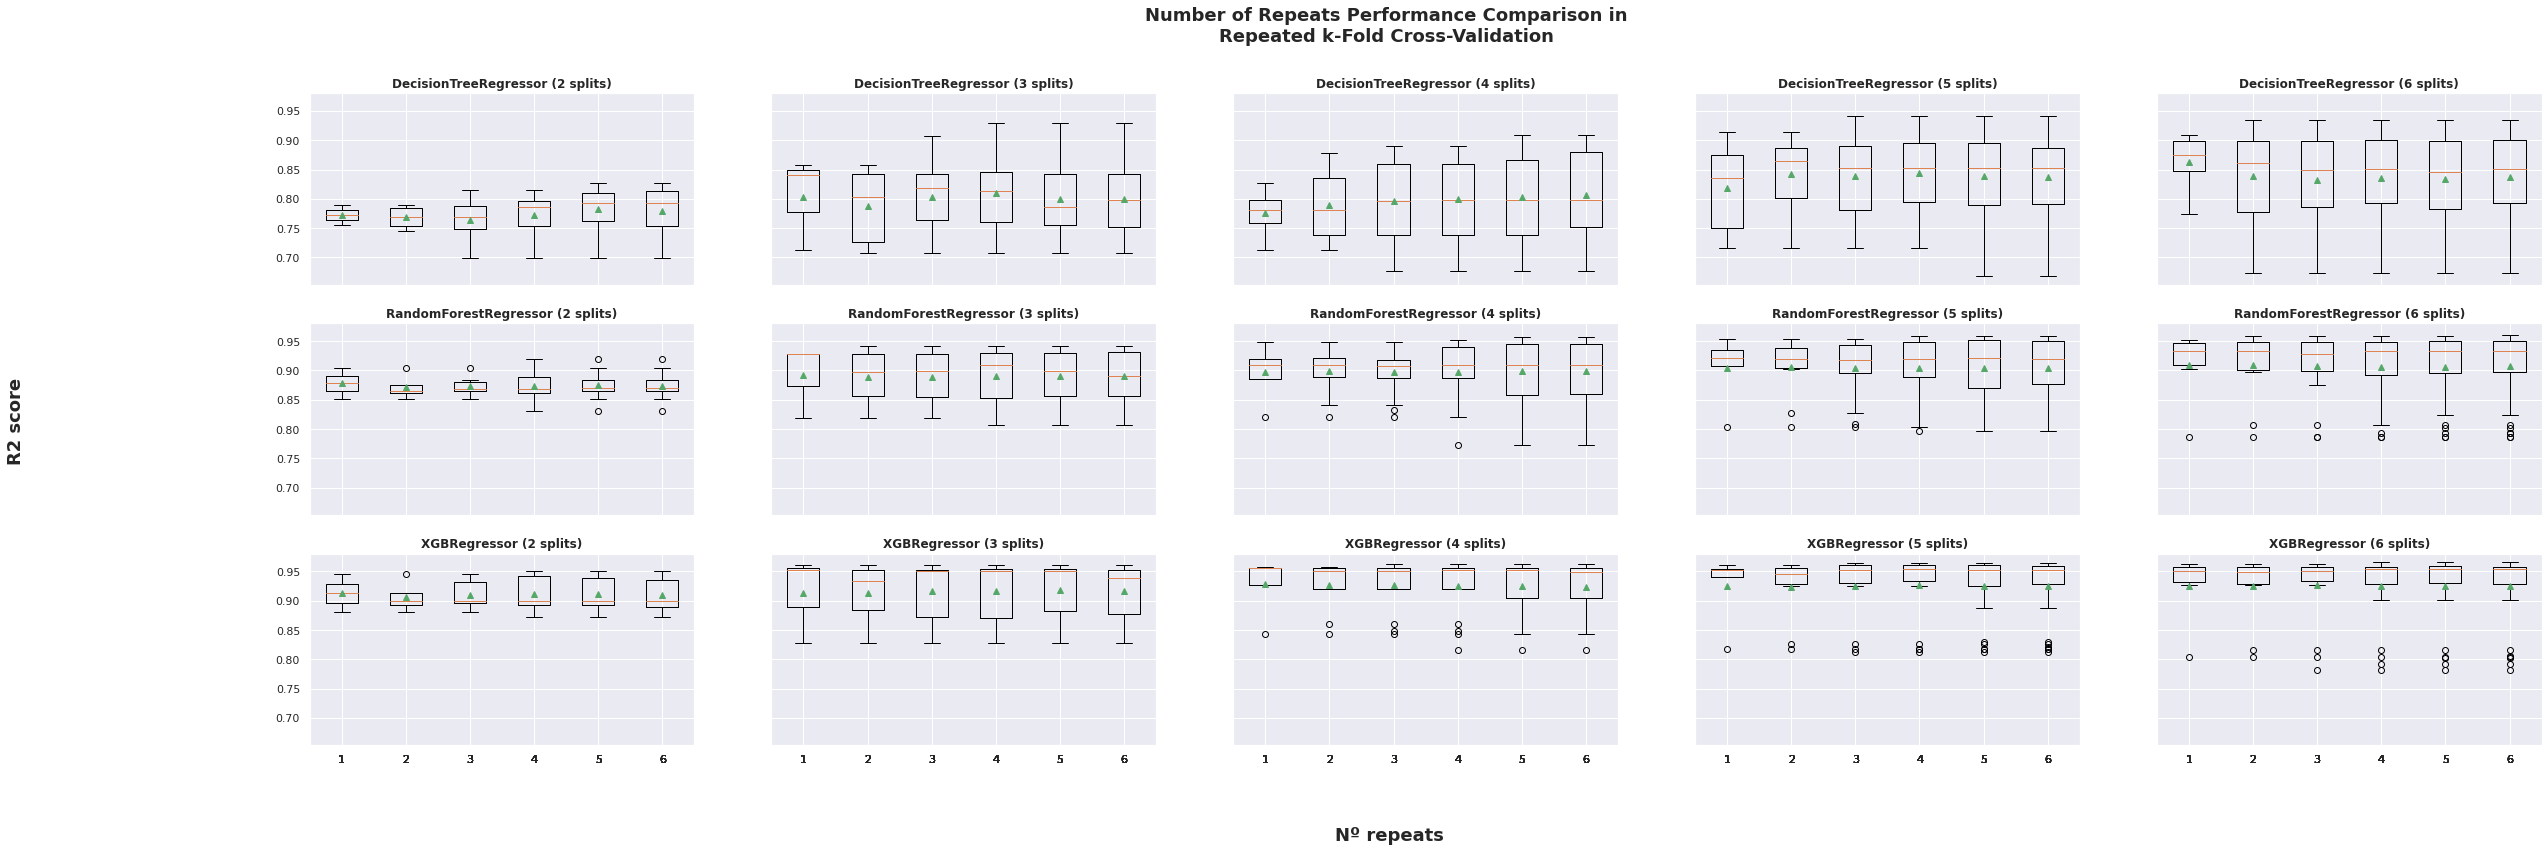

In [ ]:
max_splits = 7
max_repeats = 7
n_splits = range(2,max_splits)
n_repeats = range(1,max_repeats)

rkfcv_filename = 'rkfcv_{}_{}'.format(max_splits,max_repeats)
rkfcv_filename_path = os.path.join(exe04_tables_path, rkfcv_filename)
rkfcv_results = dict()
for model in regression_models:
    model_str = str(model).split("(")[0]
    model_filename = rkfcv_filename_path+'-'+model_str+".sav"
    print("\n{}: Model: {}".format(timenow(), model_str))
    if os.path.isfile(model_filename):
        print("\n{}: loading Repeated k-Fold Cross-Validation Scores:\t{}".format(timenow(), model_filename))
        model_file = open(model_filename, "rb")
        model_rkfcv_scores = pickle.load(model_file)
        model_file.close()
        rkfcv_results[model_str] = model_rkfcv_scores
    else:
        model_rkfcv_scores = dict()
        for n_s in n_splits:
            print("{}:\tN splits: {}".format(timenow(),n_s))
            reps_rkfcv_results = dict() 
            for n_r in n_repeats:
                print("{}:\t\tN repeats: {}".format(timenow(),n_r))
                scores = rkfcv_evaluator(X, y,model, n_s, n_r)
                print("{}:\t\t\tR2 scores:\t{}\n\t\t\t\tMean (std):\t{:.6f} ({:.6f})".format(timenow(),scores, np.mean(scores), sem(scores)))
                reps_rkfcv_results[n_r] = scores
            model_rkfcv_scores[n_s] = reps_rkfcv_results
        model_file = open(model_filename, "wb")
        pickle.dump(model_rkfcv_scores, model_file)
        model_file.close()
        rkfcv_results[model_str] = model_rkfcv_scores

rkfcv_df = rkfcv_to_df(rkfcv_results)
display(rkfcv_df)
plot_rkfcv(rkfcv_df)

In [ ]:
rkfcv_df.loc[:,"1":] = rkfcv_df.loc[:,"1":].applymap(np.mean)

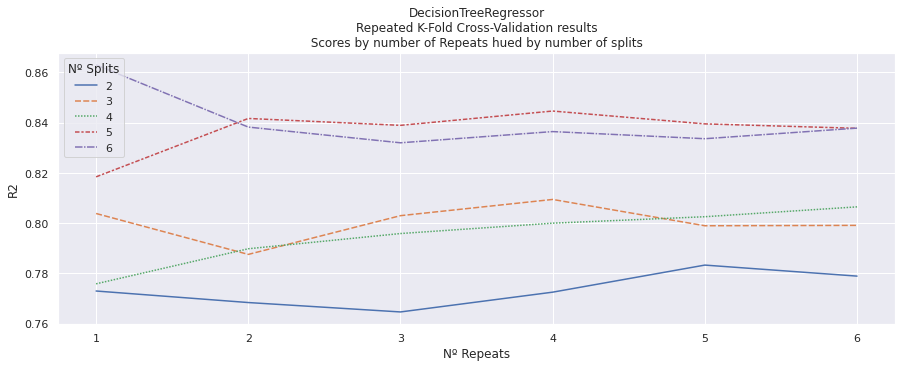

In [ ]:
DTR_rkfcv_df = rkfcv_df[rkfcv_df.model =="DecisionTreeRegressor"]
DTR_rkfcv_df.drop('model',axis=1, inplace=True)
DTR_rkfcv_df.set_index('n_splits', inplace=True)
sns.lineplot(data=DTR_rkfcv_df.T)
plt.xlabel("Nº Repeats")
plt.ylabel("R2")
plt.title("DecisionTreeRegressor\nRepeated K-Fold Cross-Validation results\n Scores by number of Repeats hued by number of splits ")
plt.legend(title="Nº Splits", loc=0)
plt.show()

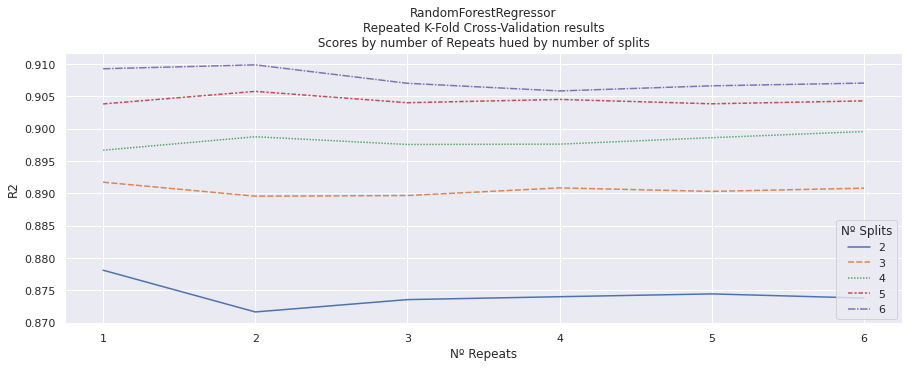

In [ ]:
RFR_rkfcv_df = rkfcv_df[rkfcv_df.model =="RandomForestRegressor"]
RFR_rkfcv_df.drop('model',axis=1, inplace=True)
RFR_rkfcv_df.set_index('n_splits', inplace=True)
sns.lineplot(data=RFR_rkfcv_df.T)
plt.xlabel("Nº Repeats")
plt.ylabel("R2")
plt.title("RandomForestRegressor\nRepeated K-Fold Cross-Validation results\n Scores by number of Repeats hued by number of splits ")
plt.legend(title="Nº Splits", loc=4)
plt.show()

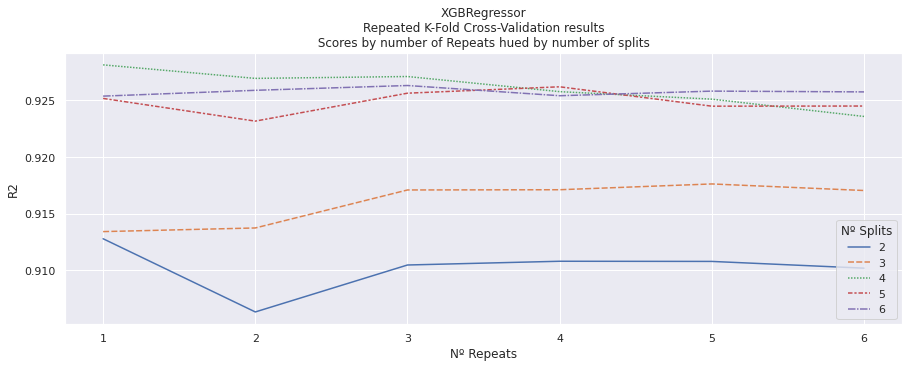

In [ ]:
XGBR_rkfcv_df = rkfcv_df[rkfcv_df.model =="XGBRegressor"]
XGBR_rkfcv_df.drop('model',axis=1, inplace=True)
XGBR_rkfcv_df.set_index('n_splits', inplace=True)
sns.lineplot(data=XGBR_rkfcv_df.T)
plt.xlabel("Nº Repeats")
plt.ylabel("R2")
plt.title("XGBRegressor\nRepeated K-Fold Cross-Validation results\n Scores by number of Repeats hued by number of splits ")
plt.legend(title="Nº Splits", loc=4)
plt.show()

At the same number of splits, increasing repetitions does not generate better results

# Exercise 5: 
  - Perform some variable engineering process to improve prediction

In [16]:
mk_dir("exe05")
exe05_models_path = mk_dir("exe05/exe05_models")
exe05_tables_path = mk_dir("exe05/exe05_tables")

Directory already existing: /content/drive/My Drive/Data_Science_amb_Python/Sprint12-Aprenentatge_Supervisat_Regressions/Supervitat_Regressio/exe05
Directory already existing: /content/drive/My Drive/Data_Science_amb_Python/Sprint12-Aprenentatge_Supervisat_Regressions/Supervitat_Regressio/exe05/exe05_models
Directory already existing: /content/drive/My Drive/Data_Science_amb_Python/Sprint12-Aprenentatge_Supervisat_Regressions/Supervitat_Regressio/exe05/exe05_tables


In [ ]:
df = pd.read_csv("DelayedFlights_Processed.csv", index_col=0)


From "DepTime" we extract the hour and minutes and assemble them with the variables "Year", "Month" and "DayofMonth" to then convert DepTime to datetime format (YYYY-MM-DD HH:MM:SS).

In [ ]:
df["DepTime"] = pd.to_datetime(dict(year=df.Year,
                                    month=df.Month,
                                    day=df.DayofMonth,
                                    hour=[t.hour for t in df.DepTime.apply(numToTime)],
                                    minute=[t.minute for t in df.DepTime.apply(numToTime)]))

Convert "DepDelay" to timedelta, so we can use it to obtain absolute differences in times.

In [ ]:
df["DepDelay"] = pd.to_timedelta(df["DepDelay"], unit='m')

Now we can get the "CRSDepTime" in datetime format by subtracting the "DepDelay" from the "DepTime"

In [ ]:
df["CRSDepTime"] = df["DepTime"] - df["DepDelay"]

Now we to transform the "DepDelay" from timedelta back to minutes

In [ ]:
df["DepDelay"] = df.DepDelay.dt.seconds/60

We sort the records, reindex and eliminate the variables "Year", "Month", "DayofMonth", "DayOfWeek".

In [ ]:
df.sort_values(by=["CRSDepTime","DepTime"], inplace=True)
df.reset_index(drop=True, inplace=True)
df = df.drop(["Year","Month","DayofMonth","DayOfWeek"], axis=1)

Now that we have "DepTime" and "CRSDepTime" in datetime format we can extract new features.

Extract cyclic time related features

In [ ]:
df["DepTime_hour"] = df.DepTime.dt.hour
df["DepTime_minute"] = df.DepTime.dt.minute
df["DepTime_month"] = df.DepTime.dt.month
df["DepTime_day"] = df.DepTime.dt.day
df["DepTime_dayofweek"] = df.DepTime.dt.dayofweek
df["DepTime_weekofyear"] = df.DepTime.dt.weekofyear
df["DepTime_dayofyear"] = df.DepTime.dt.dayofyear
df["DepTime_quarter"] = df.DepTime.dt.quarter

df["CRSDepTime_day"] = df.CRSDepTime.dt.day
df["CRSDepTime_hour"] = df.CRSDepTime.dt.hour
df["CRSDepTime_minute"] = df.CRSDepTime.dt.minute

Extract number of days in the month.

In [ ]:
df["DepTime_daysinmonth"] = df.DepTime.dt.daysinmonth

Extract bolean features

In [ ]:
df["DepTime_is_month_start"] = df.DepTime.dt.is_month_start
df["DepTime_is_month_end"] = df.DepTime.dt.is_month_end
df["DepTime_is_quarter_start"] = df.DepTime.dt.is_quarter_start
df["DepTime_is_quarter_end"] = df.DepTime.dt.is_quarter_end
df["DepTime_is_year_start"] = df.DepTime.dt.is_year_start
df["DepTime_is_year_end"] = df.DepTime.dt.is_year_end

Now we can drop "DepTime","CRSDepTime" 

In [ ]:
df = df.drop(["DepTime","CRSDepTime"], axis=1)

Convert the boolean values into integer value

In [ ]:
bool_cols = df.select_dtypes(include=["bool"]).columns.tolist()
df[bool_cols] =  df[bool_cols].astype(int)

Encode cyclical features such as all time related features into an angular distance by calculating the cosinus and sinus values of the degree.


In [ ]:
cyclic_cols = ['ArrTime', 'CRSArrTime','DepTime_month', 'DepTime_day', 
               'DepTime_hour', 'DepTime_minute', 'DepTime_weekofyear', 
               'DepTime_dayofweek', 'DepTime_dayofyear', 'DepTime_quarter', 
               'CRSDepTime_day', 'CRSDepTime_hour', 'CRSDepTime_minute']
               
cyclical = CyclicalTransformer(variables=cyclic_cols, drop_original=True)
df = cyclical.fit_transform(df)

We scale with MinMaxScaler the scalar variables such as number of minutes, number of kilometers or number of days

In [ ]:
scalar_cols = ["DepDelay","ActualElapsedTime","CRSElapsedTime","AirTime",
               "Distance","TaxiIn","TaxiOut","ArrDelay","DepTime_daysinmonth"]
minmaxscaler = MinMaxScaler()
df[scalar_cols] = minmaxscaler.fit_transform(df[scalar_cols])

We will not use the categorical variables and neither any of the "Delay" variables.

In [ ]:
object_cols = df.select_dtypes(include=["object"]).columns.tolist() + ["FlightNum"]
object_cols

['UniqueCarrier', 'TailNum', 'Origin', 'Dest', 'FlightNum']

In [ ]:
delay_cols = df.filter(regex="Delay").columns.to_list()
delay_cols

['ArrDelay',
 'DepDelay',
 'CarrierDelay',
 'WeatherDelay',
 'NASDelay',
 'SecurityDelay',
 'LateAircraftDelay']

In [ ]:
y = df[target].values
X = df.drop(labels=object_cols + delay_cols, axis=1)
X = X.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 130)

In [ ]:
model_filename_path

'/content/drive/My Drive/Data_Science_amb_Python/Sprint12-Aprenentatge_Supervisat_Regressions/Supervitat_Regressio/exe01/exe01_models/05-RandomForestRegressor.sav'

In [ ]:
metrics_lst = []
for model in regression_models:
    # Model name 
    model_str = str(model).split("(")[0]
    model_name = '{}-{}'.format("05", model_str)
    # File name
    model_filename = model_name + ".sav"
    model_filename_path = os.path.join(exe05_models_path, model_filename)
    if os.path.isfile(model_filename_path):
        # load existing model
        print("\n{}: Loading model:\t{}".format(timenow(), model_filename))
        model = pickle.load(open(model_filename_path, 'rb'))
    else:
        # Fit model
        print("\n{}: Start Fitting model:\t{}".format(timenow(), model_name))
        tiempo_inicio_fit = datetime.datetime.now()
        model.fit(X_train, y_train)
        print("{}: Finish. Fitting time:\t{}".format(timenow(), datetime.datetime.now() - tiempo_inicio_fit))

        # save the model to disk
        pickle.dump(model, open(model_filename_path, 'wb'))

    # Rename the models adding the parameters of interest
    if model_str == "DecisionTreeRegressor":
        params = '{}_{}_{}'.format(model.get_params()['criterion'], model.get_params()['max_features'], model.get_params()['splitter'])
    elif model_str == "RandomForestRegressor":
        params = '{}_{}_{}'.format(model.get_params()['criterion'], model.get_params()['max_features'], model.get_params()['n_estimators'])
    elif model_str == "XGBRegressor":
        params = '{}_{}_{}_{}'.format(model.get_params()['booster'], model.get_params()['max_depth'], model.get_params()['min_child_weight'], model.get_params()['subsample'])

    model_name = '{}-{}_-_{}'.format("05", model_str, params)
    # Evaluate model
    metrics_lst.append(reg_metrics(model_name, model, X_test, y_test))
    #Print metrics
    print("# R2:\t", r2_score(y_test, model.predict(X_test)))
    print("# MSE:\t", mean_squared_error(y_test, model.predict(X_test)))
# Tabualate resulst
reg_metrics_df = pd.concat(metrics_lst)
reg_metrics_df.sort_values(by=["R2"], ascending=False, inplace=True)
# Save results
reg_metrics_df.to_csv(os.path.join(exe05_tables_path, "05-regressors_metrics.csv"))
display(reg_metrics_df)


01:48:56: Loading model:	05-DecisionTreeRegressor.sav
# R2:	 0.7328278904164558
# MSE:	 0.0004582469295466964

01:48:56: Loading model:	05-RandomForestRegressor.sav


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


# R2:	 0.8237923666087048


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


# MSE:	 0.00030222693188340335

01:48:57: Loading model:	05-XGBRegressor.sav
# R2:	 0.8408589386887056
# MSE:	 0.00027295477370140465


,R2,MSE,MAE,MAPE,EV,ME,MedAE
05-XGBRegressor_-_gbtree_6_1_1,0.840859,0.000273,0.004431,0.063069,0.840892,0.950396,0.002664
05-RandomForestRegressor_-_squared_error_auto_100,0.823792,0.000302,0.004832,0.070195,0.823826,0.944177,0.002064
05-DecisionTreeRegressor_-_squared_error_None_best,0.732828,0.000458,0.006015,0.075372,0.732829,0.982270,0.002128


In [26]:
metrics_01_path = os.path.join(exe01_tables_path, "01-regressors_metrics.csv")
metrics_05_path = os.path.join(exe05_tables_path, "05-regressors_metrics.csv")

metrics_lst = []
for metrics_file in [metrics_01_path, metrics_05_path]:
    metrics = pd.read_csv(metrics_file, index_col=0).filter(regex=("mean_test_score|R2"))
    metrics = pd.DataFrame(data=metrics.values.round(4), index=metrics.index, columns=["R2"])
    metrics_lst.append(metrics)
final_metrics_df = pd.concat(metrics_lst)
final_metrics_df.sort_values(by=["R2"], ascending=[False], inplace=True)

data_table.enable_dataframe_formatter()
data_table.DataTable(final_metrics_df, num_rows_per_page=final_metrics_df.shape[0])

,R2
05-XGBRegressor_-_gbtree_6_1_1,0.8409
01-XGBRegressor_-_gbtree_6_1_1,0.8299
05-RandomForestRegressor_-_squared_error_auto_100,0.8238
01-RandomForestRegressor_-_squared_error_auto_100,0.8212
01-DecisionTreeRegressor_-_squared_error_None_best,0.7538
05-DecisionTreeRegressor_-_squared_error_None_best,0.7328


Using this engineering we have improved the results in XGBRegressor, and in RandomForestRegressor.

# Final summary

Based on the R2, we obtain that the best model is "03-GSCV_XGBRegressor_-_gbtree_5_2_1".

In [17]:
metrics_lst = []
for metrics_file in glob.glob(cwd+ "/**/*_metrics.csv", recursive=True):
    metrics = pd.read_csv(metrics_file, index_col=0).filter(regex=("mean_test_score|R2"))
    metrics = pd.DataFrame(data=metrics.values.round(4), index=metrics.index, columns=["R2"])
    metrics_lst.append(metrics)
final_metrics_df = pd.concat(metrics_lst)
final_metrics_df.sort_values(by=["R2"], ascending=[False], inplace=True)

data_table.enable_dataframe_formatter()
data_table.DataTable(final_metrics_df, num_rows_per_page=final_metrics_df.shape[0])

,R2
03-GSCV_XGBRegressor_-_gbtree_5_2_1,0.9165
03-GSCV_XGBRegressor_-_gbtree_5_1_1,0.9124
03-GSCV_XGBRegressor_-_gbtree_6_2_1,0.9086
03-GSCV_XGBRegressor_-_gbtree_6_1_1,0.9066
03-GSCV_XGBRegressor_-_gbtree_6_2_0.5,0.9010
03-GSCV_XGBRegressor_-_gbtree_6_1_0.5,0.9006
03-GSCV_XGBRegressor_-_gbtree_5_2_0.5,0.8874
03-GSCV_XGBRegressor_-_gbtree_5_1_0.5,0.8847
03-GSCV_RandomForestRegressor_-_squared_error_None_150,0.8669
03-GSCV_RandomForestRegressor_-_squared_error_auto_150,0.8669


<AxesSubplot:xlabel='R2'>

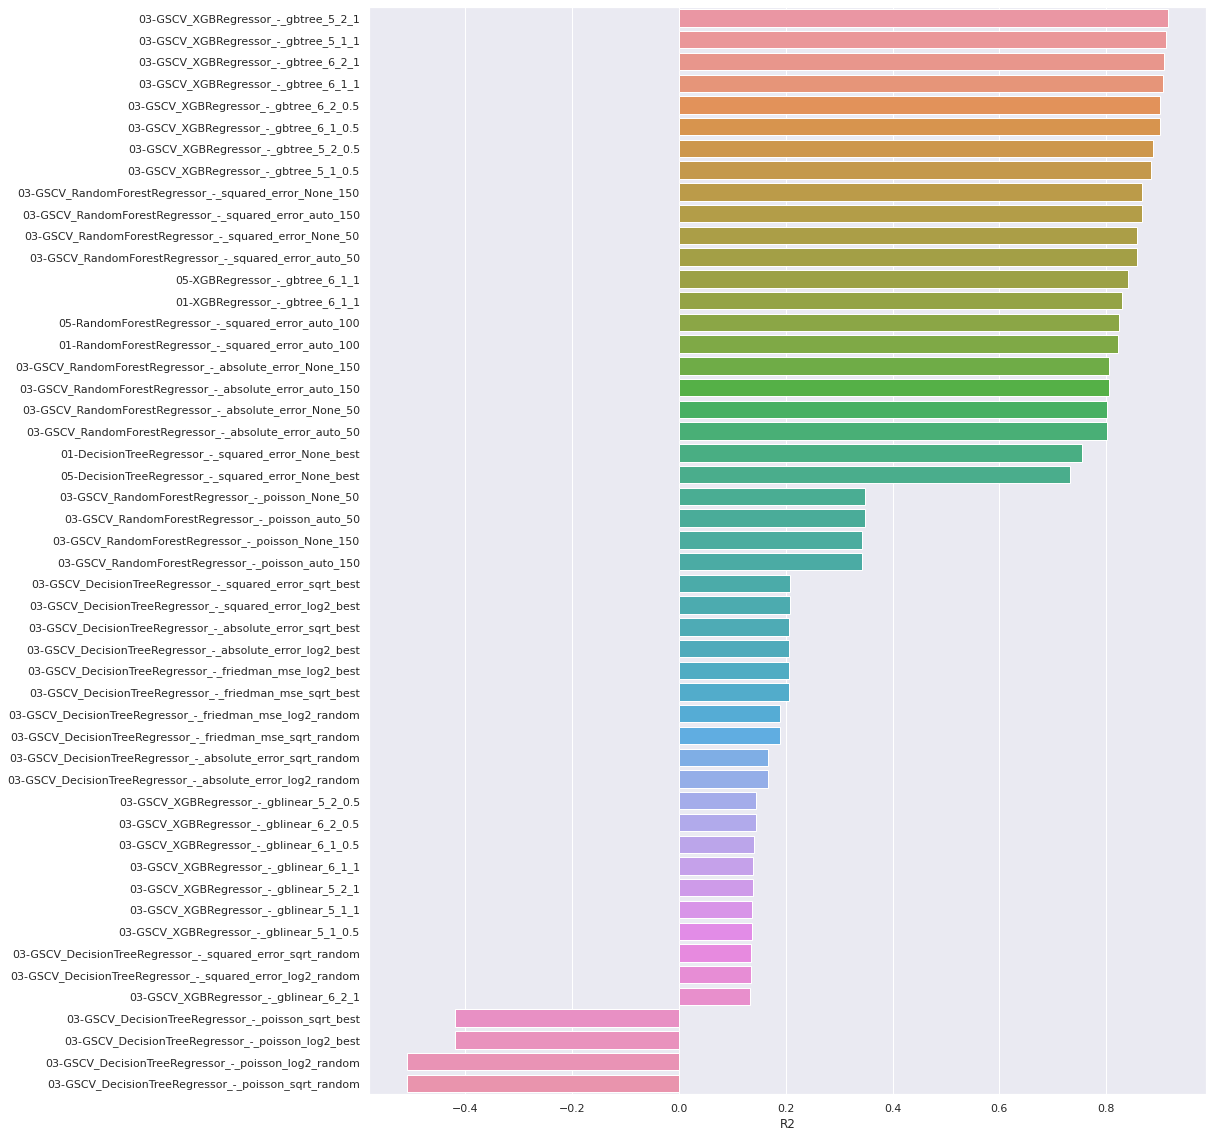

In [18]:
plt.figure(figsize = (15,20))
sns.barplot(data=final_metrics_df, x = "R2", y = final_metrics_df.index)